In [1]:
from pathlib import Path

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

from PIL import Image
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import Callback
from timeit import default_timer as timer

import itertools 

2023-05-15 16:29:37.169260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Importer le DataFrame
df = pd.read_csv("V2_Plant_Seedlings_DataFrame.csv", sep=';')
df.head()

,filepath,species,image_name,height,width,R_mean,G_mean,B_mean,luminosity,blur_score,image_size,sharpness_score,square
0,/Users/thithaotrucle/Documents/Projet fil roug...,Black-grass,1.png,138,138,105.075247,98.336957,89.631590,97.681264,151.874492,19044,8.365028,square
1,/Users/thithaotrucle/Documents/Projet fil roug...,Black-grass,10.png,1040,1040,79.711614,68.709711,60.161677,69.527667,133.348355,1081600,367.182903,square
2,/Users/thithaotrucle/Documents/Projet fil roug...,Black-grass,100.png,82,82,111.598602,103.431440,92.232302,102.420781,131.975238,6724,2.803053,square
3,/Users/thithaotrucle/Documents/Projet fil roug...,Black-grass,101.png,156,156,84.529668,67.176446,48.901833,66.869316,132.849602,24336,8.426078,square
4,/Users/thithaotrucle/Documents/Projet fil roug...,Black-grass,102.png,197,197,88.982092,72.174805,53.490505,71.549134,108.609648,38809,12.779936,square


In [3]:
# Train/test split
train_df,test_df = train_test_split(df,
                                    test_size=0.2,
                                    random_state=3,
                                    shuffle=True,
                                    stratify=df['species'])

In [4]:
# Paramètres de preprocessing
color_mode = 'rgb'
target_size = (224,224)
channels = 3
batch_size = 32

In [5]:
# Instanciation du générateur de données
train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                          rotation_range=90,
                                          width_shift_range=0.05, 
                                          height_shift_range=0.05,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          validation_split=0.2)

test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [6]:
# Instanciation des itérateurs
train_iterator = train_data_generator.flow_from_dataframe(train_df,
                                                           x_col='filepath',
                                                           y_col='species',
                                                           target_size=target_size,
                                                           color_mode=color_mode,
                                                           class_mode='sparse',
                                                           batch_size=batch_size,
                                                           subset="training")
validation_iterator = train_data_generator.flow_from_dataframe(train_df,
                                                               x_col='filepath',
                                                               y_col='species',
                                                               target_size=target_size,
                                                               color_mode=color_mode,
                                                               class_mode='sparse',
                                                               batch_size=batch_size,
                                                               subset="validation")

test_iterator = test_data_generator.flow_from_dataframe(test_df,
                                                         x_col='filepath',
                                                         y_col='species',
                                                         target_size=target_size,
                                                         color_mode=color_mode,
                                                         class_mode='sparse',
                                                         batch_size=batch_size,
                                                         shuffle=False)


Found 3545 validated image filenames belonging to 12 classes.
Found 886 validated image filenames belonging to 12 classes.
Found 1108 validated image filenames belonging to 12 classes.


In [7]:
# Transfer learning sur la base du modèle MobileNetV2

# Etape 1: Entraînement avec les poids du modèle MobileNetV2 pré-entraîné sur la base ImageNet

# Chargement du modèle de base pré-entraîné
base_model = MobileNetV2(include_top = False,
                        weights = 'imagenet',
                        pooling='avg')
base_model.summary()

# Freeze des poids du modèle de base
for layer in base_model.layers:
    layer.trainable = False    

2023-05-15 16:30:39.096213: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                            

                                                                                                  
 block_3_expand (Conv2D)        (None, None, None,   3456        ['block_2_add[0][0]']            
                                144)                                                              
                                                                                                  
 block_3_expand_BN (BatchNormal  (None, None, None,   576        ['block_3_expand[0][0]']         
 ization)                       144)                                                              
                                                                                                  
 block_3_expand_relu (ReLU)     (None, None, None,   0           ['block_3_expand_BN[0][0]']      
                                144)                                                              
                                                                                                  
 block_3_p

                                192)                                                              
                                                                                                  
 block_6_expand_BN (BatchNormal  (None, None, None,   768        ['block_6_expand[0][0]']         
 ization)                       192)                                                              
                                                                                                  
 block_6_expand_relu (ReLU)     (None, None, None,   0           ['block_6_expand_BN[0][0]']      
                                192)                                                              
                                                                                                  
 block_6_pad (ZeroPadding2D)    (None, None, None,   0           ['block_6_expand_relu[0][0]']    
                                192)                                                              
          

 block_9_expand_BN (BatchNormal  (None, None, None,   1536       ['block_9_expand[0][0]']         
 ization)                       384)                                                              
                                                                                                  
 block_9_expand_relu (ReLU)     (None, None, None,   0           ['block_9_expand_BN[0][0]']      
                                384)                                                              
                                                                                                  
 block_9_depthwise (DepthwiseCo  (None, None, None,   3456       ['block_9_expand_relu[0][0]']    
 nv2D)                          384)                                                              
                                                                                                  
 block_9_depthwise_BN (BatchNor  (None, None, None,   1536       ['block_9_depthwise[0][0]']      
 malizatio

                                                                                                  
 block_12_depthwise (DepthwiseC  (None, None, None,   5184       ['block_12_expand_relu[0][0]']   
 onv2D)                         576)                                                              
                                                                                                  
 block_12_depthwise_BN (BatchNo  (None, None, None,   2304       ['block_12_depthwise[0][0]']     
 rmalization)                   576)                                                              
                                                                                                  
 block_12_depthwise_relu (ReLU)  (None, None, None,   0          ['block_12_depthwise_BN[0][0]']  
                                576)                                                              
                                                                                                  
 block_12_

 onv2D)                         960)                                                              
                                                                                                  
 block_15_depthwise_BN (BatchNo  (None, None, None,   3840       ['block_15_depthwise[0][0]']     
 rmalization)                   960)                                                              
                                                                                                  
 block_15_depthwise_relu (ReLU)  (None, None, None,   0          ['block_15_depthwise_BN[0][0]']  
                                960)                                                              
                                                                                                  
 block_15_project (Conv2D)      (None, None, None,   153600      ['block_15_depthwise_relu[0][0]']
                                160)                                                              
          

In [8]:
# Création du modèle complet: construction fonctionnelle

inputs = Input(shape=(target_size[0],target_size[1],channels),name='Input')
          
# Définition des couches de classification
classif_layer1 = Dropout(rate=0.2,name='Dropout_layer_1')
classif_layer2 = Dense(units=256,activation='relu',name='Dense_layer_1')
classif_layer3 = Dropout(rate=0.2,name='Dropout_layer_2')
classif_layer4 = Dense(units=128,activation='relu',name='Dense_layer_2')
classif_layer5 = Dropout(rate=0.2,name='Dropout_layer_3')
output_layer = Dense(units=12,activation='softmax',name='Dense_layer_output')

# Assemblage du modèle
x = base_model(inputs)
x = classif_layer1(x)
x = classif_layer2(x)
x = classif_layer3(x)
x = classif_layer4(x)
x = classif_layer5(x)
outputs = output_layer(x)

model = Model(inputs = inputs, outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 Dropout_layer_1 (Dropout)   (None, 1280)              0         
                                                                 
 Dense_layer_1 (Dense)       (None, 256)               327936    
                                                                 
 Dropout_layer_2 (Dropout)   (None, 256)               0         
                                                                 
 Dense_layer_2 (Dense)       (None, 128)               32896     
                                                             

In [9]:
# Définition des callbacks EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_accuracy',
                               min_delta=0.01,
                               mode='max',
                               patience=5,
                               restore_best_weights=True,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                         factor=0.5,
                                         min_delta=0.01,
                                         mode='max',
                                         patience=3,
                                         verbose=1)


# Définition d'un callback mesurant la durée de l'entraînement 
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_train_begin(self, logs={}):
        self.starttime = timer()
    def on_train_end(self, logs={}):
        self.logs.append(timer()-self.starttime)

time_callback = TimingCallback()

In [10]:
# Fonction permettant de charger un éventuel modèle précédemment entraîné, de compiler et de lancer l'entraînement

def model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=None,lr=1.e-3,nb_epochs=30):
    
    # Chargement des poids obtenus lors d'un précédent entraînement
    if loadweights_filepath != None:
        model.load_weights(loadweights_filepath)
        
    # Compilation
    model.compile(optimizer=Adam(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics='accuracy')
    
    # Définition du ModelCheckPoint
    model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                       monitor='val_accuracy',
                                       mode='max',
                                       save_best_only = True,
                                       save_weights_only = True,
                                       verbose=1)
    
    # Définition du CSV Logger (enregistrement de l'historique d'entraînement)
    csv_logger = CSVLogger(csvlogger_filepath,append=True)
    
    # Entraînement
    training_history = model.fit(train_iterator,validation_data=validation_iterator,
                                 epochs=nb_epochs,
                                 steps_per_epoch=train_iterator.samples//batch_size,
                                 validation_steps=validation_iterator.samples//batch_size,
                                 callbacks=[time_callback,reduce_learning_rate,model_checkpoint,csv_logger],
                                 verbose=True)


In [11]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_DeFreeze','Freeze','best_weights.ckpt')
csvlogger_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_Defreeze','Freeze','training_history.csv')

In [12]:
# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath)

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 1.7001 - accuracy: 0.4338
Epoch 1: val_accuracy improved from -inf to 0.66204, saving model to Models_training/MobileNetV2_SansSeg_SansZoom_DeFreeze/Freeze/best_weights.ckpt
110/110 [==============================] - 73s 652ms/step - loss: 1.7001 - accuracy: 0.4338 - val_loss: 1.0145 - val_accuracy: 0.6620 - lr: 0.0010
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 1.0789 - accuracy: 0.6134
Epoch 2: val_accuracy improved from 0.66204 to 0.72222, saving model to Models_training/MobileNetV2_SansSeg_SansZoom_DeFreeze/Freeze/best_weights.ckpt
110/110 [==============================] - 71s 643ms/step - loss: 1.0789 - accuracy: 0.6134 - val_loss: 0.7819 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.9174 - accuracy: 0.6667
Epoch 3: val_accuracy improved from 0.72222 to 0.76736, saving model to Models_training/MobileNetV2_SansSeg_SansZoom_De

110/110 [==============================] - 82s 744ms/step - loss: 0.4491 - accuracy: 0.8355 - val_loss: 0.4474 - val_accuracy: 0.8310 - lr: 2.5000e-04
Epoch 24/30
110/110 [==============================] - ETA: 0s - loss: 0.4206 - accuracy: 0.8466
Epoch 24: val_accuracy did not improve from 0.84838
110/110 [==============================] - 80s 726ms/step - loss: 0.4206 - accuracy: 0.8466 - val_loss: 0.4285 - val_accuracy: 0.8322 - lr: 1.2500e-04
Epoch 25/30
110/110 [==============================] - ETA: 0s - loss: 0.4120 - accuracy: 0.8540
Epoch 25: val_accuracy did not improve from 0.84838
110/110 [==============================] - 80s 725ms/step - loss: 0.4120 - accuracy: 0.8540 - val_loss: 0.4298 - val_accuracy: 0.8310 - lr: 1.2500e-04
Epoch 26/30
110/110 [==============================] - ETA: 0s - loss: 0.4153 - accuracy: 0.8506
Epoch 26: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 26: val_accuracy did not improve from 0.84838
110/110 [==============

In [13]:
# Calcul de la durée de l'entrainement
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 37.0 minutes.


In [14]:
# Résultats de l'entrainement 
training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
training_history.head()

,accuracy,loss,lr,val_accuracy,val_loss
epoch,,,,,
0,0.433817,1.700120,0.001,0.662037,1.014548
1,0.613436,1.078871,0.001,0.722222,0.781930
2,0.666667,0.917383,0.001,0.767361,0.674870
3,0.703957,0.822290,0.001,0.771991,0.655242
4,0.712212,0.764109,0.001,0.775463,0.623585


In [15]:
# Trouve l'index de la ligne avec la valeur maximale de val_accuracy
max_val_accuracy_idx = training_history['val_accuracy'].idxmax()

# Sélectionne la ligne correspondante et affiche toutes les colonnes
row_with_max_val_accuracy = training_history.loc[max_val_accuracy_idx]
print('Valeurs Max')
print(row_with_max_val_accuracy)

# Trouve l'index de la ligne avec la valeur min de val_accuracy
min_val_accuracy_idx = training_history['val_accuracy'].idxmin()

# Sélectionne la ligne correspondante et affiche toutes les colonnes
row_with_min_val_accuracy = training_history.loc[min_val_accuracy_idx]
print('Valeurs Min')
print(row_with_min_val_accuracy)

column_means = training_history.mean()
print('Valeurs Moyennes')
print(column_means)

Valeurs Max
accuracy        0.852548
loss            0.400148
lr              0.000063
val_accuracy    0.864583
val_loss        0.397651
Name: 29, dtype: float64
Valeurs Min
accuracy        0.433817
loss            1.700120
lr              0.001000
val_accuracy    0.662037
val_loss        1.014548
Name: 0, dtype: float64
Valeurs Moyennes
accuracy        0.785122
loss            0.595131
lr              0.000579
val_accuracy    0.813927
val_loss        0.517001
dtype: float64


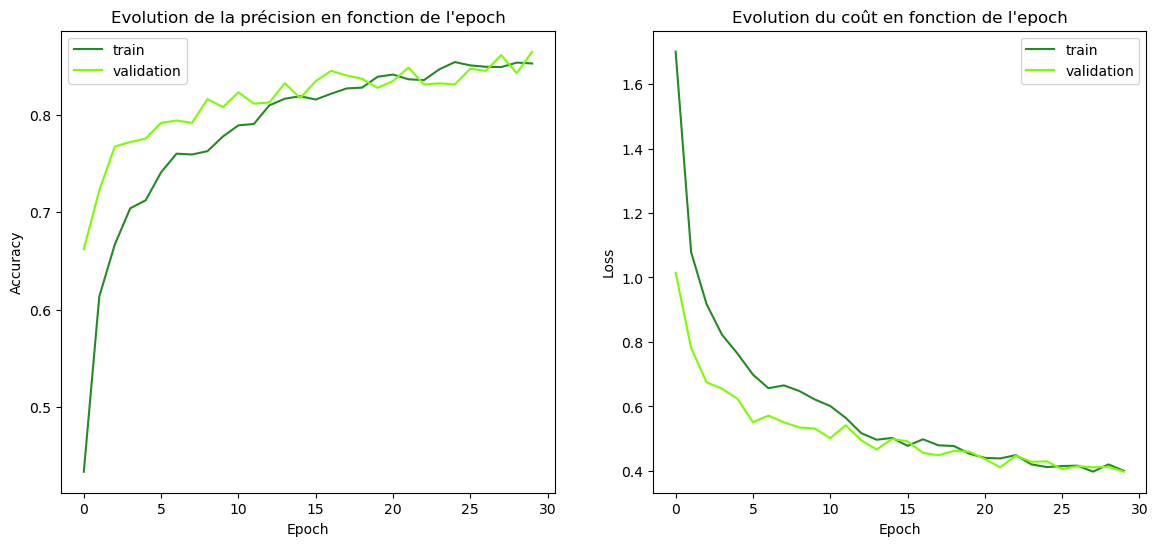

In [18]:
# Tracé des courbes de précision et de cout en fonction de l'epoch

def plot_history():
    #Afficher la courbe de la fonction de coût et de précision en fonction de l'epoch
    training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    ax[0].plot(training_history['accuracy'], color='forestgreen')
    ax[0].plot(training_history['val_accuracy'], color='lawngreen')
    ax[0].set_title("Evolution de la précision en fonction de l'epoch")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(['train', 'validation'], loc='best');
    ax[1].plot(training_history['loss'], color='forestgreen')
    ax[1].plot(training_history['val_loss'], color='lawngreen')
    ax[1].set_title("Evolution du coût en fonction de l'epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend(['train', 'validation'], loc='best');

plot_history()
plt.show()

In [19]:
model.load_weights(checkpoint_filepath)

35/35 [==============================] - 11s 287ms/step
                           precision    recall  f1-score   support

              Black-grass       0.60      0.58      0.59        62
                 Charlock       0.98      0.91      0.94        90
                 Cleavers       0.91      0.93      0.92        67
         Common Chickweed       0.91      0.74      0.82       143
             Common wheat       0.85      0.78      0.82        51
                  Fat Hen       0.89      0.87      0.88       108
         Loose Silky-bent       0.79      0.87      0.82       152
                    Maize       0.94      0.92      0.93        51
        Scentless Mayweed       0.72      0.88      0.79       121
         Shepherd’s Purse       0.75      0.73      0.74        55
Small-flowered Cranesbill       0.96      0.95      0.95       115
               Sugar beet       0.92      0.94      0.93        93

                 accuracy                           0.85      1108
    

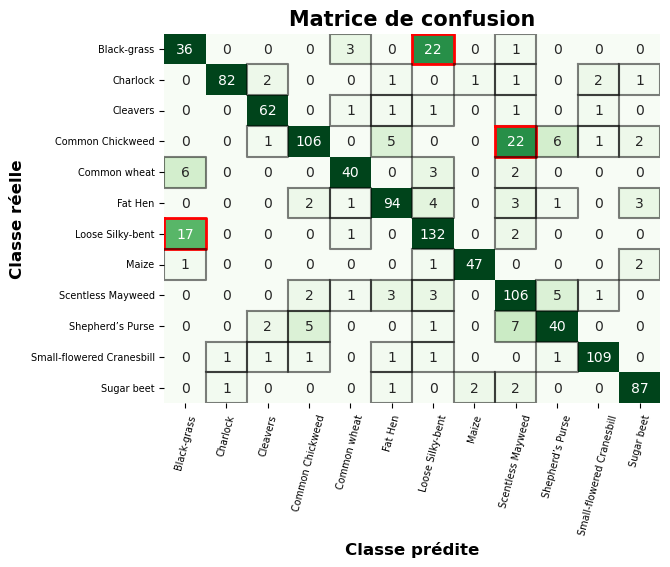

In [21]:
# Rapport de classification et matrice de confusion
def show_metrics():
    y_true = test_iterator.classes #ou .labels
    y_pred = model.predict(test_iterator).argmax(axis=-1)
    #Evaluation du modèle : rapport de classification & matrice de confusion
    print(classification_report(y_true, y_pred, target_names = df.species.unique()))
    matrix = confusion_matrix(y_true, y_pred)
    classes = df.species.unique()
    sns.heatmap(matrix, annot=True,cmap="Greens", fmt = 'd',vmin=0,vmax=30,cbar=False)
    tick_marks = np.arange(0.5, len(classes), 1)
    plt.xticks(tick_marks, classes, rotation=75, fontsize = 7)
    plt.yticks(tick_marks, classes, rotation=0, fontsize = 7)
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        if (i!=j) and (matrix[i,j] !=0):
            if (matrix[i,j] > matrix.mean()):
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="red", linewidth=2)
            else:
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="k", alpha = 0.5)
    plt.ylabel("Classe réelle", fontweight = 'bold', fontsize = 12)
    plt.xlabel("Classe prédite", fontweight = 'bold', fontsize = 12)
    plt.title("Matrice de confusion", fontweight = 'extra bold', fontsize = 15);
    
show_metrics()
plt.show()

In [22]:
# Etape 2: Fine-tuning du modèle par "dé-freeze" du modèle de base et ajustement du learning rate

# Identification des couches à dé-freezer
for i,layer in enumerate(base_model.layers):
    print(i,layer.name,"Trainable:",layer.trainable)

0 input_1 Trainable: False
1 Conv1 Trainable: False
2 bn_Conv1 Trainable: False
3 Conv1_relu Trainable: False
4 expanded_conv_depthwise Trainable: False
5 expanded_conv_depthwise_BN Trainable: False
6 expanded_conv_depthwise_relu Trainable: False
7 expanded_conv_project Trainable: False
8 expanded_conv_project_BN Trainable: False
9 block_1_expand Trainable: False
10 block_1_expand_BN Trainable: False
11 block_1_expand_relu Trainable: False
12 block_1_pad Trainable: False
13 block_1_depthwise Trainable: False
14 block_1_depthwise_BN Trainable: False
15 block_1_depthwise_relu Trainable: False
16 block_1_project Trainable: False
17 block_1_project_BN Trainable: False
18 block_2_expand Trainable: False
19 block_2_expand_BN Trainable: False
20 block_2_expand_relu Trainable: False
21 block_2_depthwise Trainable: False
22 block_2_depthwise_BN Trainable: False
23 block_2_depthwise_relu Trainable: False
24 block_2_project Trainable: False
25 block_2_project_BN Trainable: False
26 block_2_add Tr

In [23]:
# Etape 2.1: Dé-freeze des 2 derniers blocs (15 et 16) du modèle de base
for layer in base_model.layers[134:]:
    layer.trainable = True
    
for i,layer in enumerate(base_model.layers):
    print(i,layer.name,"Trainable:",layer.trainable)

0 input_1 Trainable: False
1 Conv1 Trainable: False
2 bn_Conv1 Trainable: False
3 Conv1_relu Trainable: False
4 expanded_conv_depthwise Trainable: False
5 expanded_conv_depthwise_BN Trainable: False
6 expanded_conv_depthwise_relu Trainable: False
7 expanded_conv_project Trainable: False
8 expanded_conv_project_BN Trainable: False
9 block_1_expand Trainable: False
10 block_1_expand_BN Trainable: False
11 block_1_expand_relu Trainable: False
12 block_1_pad Trainable: False
13 block_1_depthwise Trainable: False
14 block_1_depthwise_BN Trainable: False
15 block_1_depthwise_relu Trainable: False
16 block_1_project Trainable: False
17 block_1_project_BN Trainable: False
18 block_2_expand Trainable: False
19 block_2_expand_BN Trainable: False
20 block_2_expand_relu Trainable: False
21 block_2_depthwise Trainable: False
22 block_2_depthwise_BN Trainable: False
23 block_2_depthwise_relu Trainable: False
24 block_2_project Trainable: False
25 block_2_project_BN Trainable: False
26 block_2_add Tr

In [25]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_DeFreeze','DeFreeze_1','best_weights.ckpt')
csvlogger_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_Defreeze','DeFreeze_1','training_history.csv')
loadweights_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_DeFreeze','Freeze','best_weights.ckpt')
lr=1.e-4
nb_epochs=30

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)


Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 0.8469 - accuracy: 0.7199
Epoch 1: val_accuracy improved from -inf to 0.78356, saving model to Models_training/MobileNetV2_SansSeg_SansZoom_DeFreeze/DeFreeze_1/best_weights.ckpt
110/110 [==============================] - 78s 692ms/step - loss: 0.8469 - accuracy: 0.7199 - val_loss: 0.8161 - val_accuracy: 0.7836 - lr: 1.0000e-04
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 0.4912 - accuracy: 0.8369
Epoch 2: val_accuracy did not improve from 0.78356
110/110 [==============================] - 74s 675ms/step - loss: 0.4912 - accuracy: 0.8369 - val_loss: 1.4049 - val_accuracy: 0.7106 - lr: 1.0000e-04
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.4404 - accuracy: 0.8477
Epoch 3: val_accuracy did not improve from 0.78356
110/110 [==============================] - 74s 673ms/step - loss: 0.4404 - accuracy: 0.8477 - val_loss: 1.5465 - val_accuracy: 0.6794 - lr: 1.0000e-04
Epoch

110/110 [==============================] - 72s 656ms/step - loss: 0.2019 - accuracy: 0.9271 - val_loss: 0.3068 - val_accuracy: 0.9016 - lr: 1.2500e-05
Epoch 24/30
110/110 [==============================] - ETA: 0s - loss: 0.1830 - accuracy: 0.9311
Epoch 24: val_accuracy did not improve from 0.90162
110/110 [==============================] - 72s 652ms/step - loss: 0.1830 - accuracy: 0.9311 - val_loss: 0.3285 - val_accuracy: 0.8924 - lr: 1.2500e-05
Epoch 25/30
110/110 [==============================] - ETA: 0s - loss: 0.1940 - accuracy: 0.9249
Epoch 25: val_accuracy improved from 0.90162 to 0.90509, saving model to Models_training/MobileNetV2_SansSeg_SansZoom_DeFreeze/DeFreeze_1/best_weights.ckpt
110/110 [==============================] - 72s 654ms/step - loss: 0.1940 - accuracy: 0.9249 - val_loss: 0.3242 - val_accuracy: 0.9051 - lr: 1.2500e-05
Epoch 26/30
110/110 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.9351
Epoch 26: ReduceLROnPlateau reducing learning ra

In [26]:
# Calcul de la durée de l'entrainement
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")# Résultats de l'entrainement 

Durée de l'entraînement: 36.0 minutes.


In [27]:
training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
training_history.head()

,accuracy,loss,lr,val_accuracy,val_loss
epoch,,,,,
0,0.729576,0.817481,0.00010,0.792824,0.746719
1,0.822089,0.492205,0.00010,0.712963,1.338185
2,0.850270,0.433707,0.00010,0.780093,0.935189
3,0.861657,0.387508,0.00010,0.740741,1.184988
4,0.872758,0.358397,0.00005,0.825231,0.687508


In [28]:
# Trouve l'index de la ligne avec la valeur maximale de val_accuracy
max_val_accuracy_idx = training_history['val_accuracy'].idxmax()

# Sélectionne la ligne correspondante et affiche toutes les colonnes
row_with_max_val_accuracy = training_history.loc[max_val_accuracy_idx]
print('Valeurs Max')
print(row_with_max_val_accuracy)

# Trouve l'index de la ligne avec la valeur min de val_accuracy
min_val_accuracy_idx = training_history['val_accuracy'].idxmin()

# Sélectionne la ligne correspondante et affiche toutes les colonnes
row_with_min_val_accuracy = training_history.loc[min_val_accuracy_idx]
print('Valeurs Min')
print(row_with_min_val_accuracy)

column_means = training_history.mean()
print('Valeurs Moyennes')
print(column_means)

Valeurs Max
       accuracy      loss        lr  val_accuracy  val_loss
epoch                                                      
28     0.927982  0.207686  0.000006      0.896991  0.292237
28     0.942499  0.166951  0.000006      0.914352  0.285043
Valeurs Min
       accuracy      loss      lr  val_accuracy  val_loss
epoch                                                    
2      0.850270  0.433707  0.0001      0.780093  0.935189
2      0.847709  0.440434  0.0001      0.679398  1.546493
Valeurs Moyennes
accuracy        0.900871
loss            0.277900
lr              0.000039
val_accuracy    0.855343
val_loss        0.533144
dtype: float64


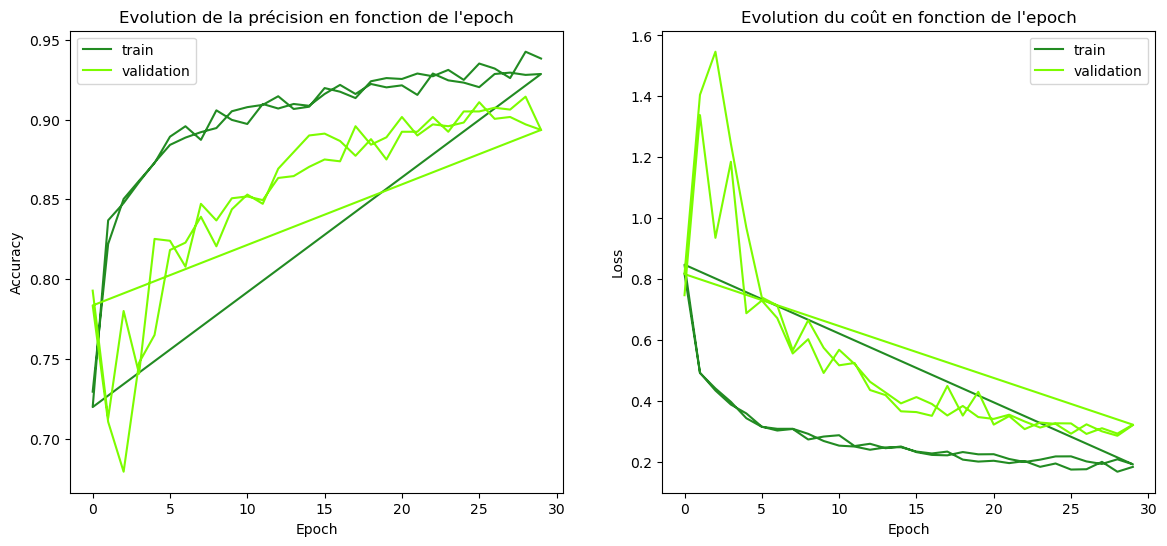

In [29]:
def plot_history():
    #Afficher la courbe de la fonction de coût et de précision en fonction de l'epoch
    training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    ax[0].plot(training_history['accuracy'], color='forestgreen')
    ax[0].plot(training_history['val_accuracy'], color='lawngreen')
    ax[0].set_title("Evolution de la précision en fonction de l'epoch")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(['train', 'validation'], loc='best');
    ax[1].plot(training_history['loss'], color='forestgreen')
    ax[1].plot(training_history['val_loss'], color='lawngreen')
    ax[1].set_title("Evolution du coût en fonction de l'epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend(['train', 'validation'], loc='best');

plot_history()
plt.show()

In [30]:
model.load_weights(checkpoint_filepath)

35/35 [==============================] - 12s 312ms/step
                           precision    recall  f1-score   support

              Black-grass       0.65      0.56      0.60        62
                 Charlock       0.98      0.96      0.97        90
                 Cleavers       0.97      0.96      0.96        67
         Common Chickweed       0.93      0.96      0.94       143
             Common wheat       0.90      0.86      0.88        51
                  Fat Hen       0.98      0.89      0.93       108
         Loose Silky-bent       0.80      0.89      0.84       152
                    Maize       0.91      0.94      0.92        51
        Scentless Mayweed       0.89      0.90      0.89       121
         Shepherd’s Purse       0.82      0.82      0.82        55
Small-flowered Cranesbill       0.99      0.95      0.97       115
               Sugar beet       0.93      0.95      0.94        93

                 accuracy                           0.90      1108
    

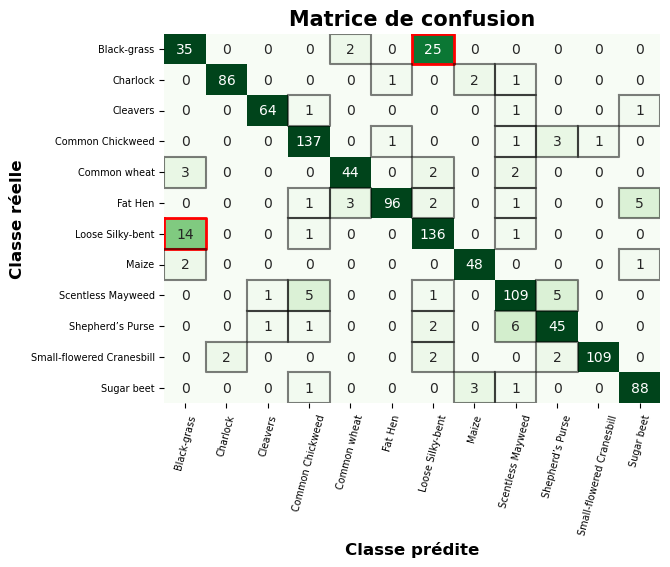

In [31]:
def show_metrics():
    y_true = test_iterator.classes #ou .labels
    y_pred = model.predict(test_iterator).argmax(axis=-1)
    #Evaluation du modèle : rapport de classification & matrice de confusion
    print(classification_report(y_true, y_pred, target_names = df.species.unique()))
    matrix = confusion_matrix(y_true, y_pred)
    classes = df.species.unique()
    sns.heatmap(matrix, annot=True,cmap="Greens", fmt = 'd',vmin=0,vmax=30,cbar=False)
    tick_marks = np.arange(0.5, len(classes), 1)
    plt.xticks(tick_marks, classes, rotation=75, fontsize = 7)
    plt.yticks(tick_marks, classes, rotation=0, fontsize = 7)
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        if (i!=j) and (matrix[i,j] !=0):
            if (matrix[i,j] > matrix.mean()):
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="red", linewidth=2)
            else:
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="k", alpha = 0.5)
    plt.ylabel("Classe réelle", fontweight = 'bold', fontsize = 12)
    plt.xlabel("Classe prédite", fontweight = 'bold', fontsize = 12)
    plt.title("Matrice de confusion", fontweight = 'extra bold', fontsize = 15);
    
show_metrics()
plt.show()

In [33]:
# Etape 2.2: Dé-freeze des 4 derniers blocs (13 et 14) du modèle de base
for layer in base_model.layers[116:]:
    layer.trainable = True
    
for i,layer in enumerate(base_model.layers):
    print(i,layer.name,"Trainable:",layer.trainable)

0 input_1 Trainable: False
1 Conv1 Trainable: False
2 bn_Conv1 Trainable: False
3 Conv1_relu Trainable: False
4 expanded_conv_depthwise Trainable: False
5 expanded_conv_depthwise_BN Trainable: False
6 expanded_conv_depthwise_relu Trainable: False
7 expanded_conv_project Trainable: False
8 expanded_conv_project_BN Trainable: False
9 block_1_expand Trainable: False
10 block_1_expand_BN Trainable: False
11 block_1_expand_relu Trainable: False
12 block_1_pad Trainable: False
13 block_1_depthwise Trainable: False
14 block_1_depthwise_BN Trainable: False
15 block_1_depthwise_relu Trainable: False
16 block_1_project Trainable: False
17 block_1_project_BN Trainable: False
18 block_2_expand Trainable: False
19 block_2_expand_BN Trainable: False
20 block_2_expand_relu Trainable: False
21 block_2_depthwise Trainable: False
22 block_2_depthwise_BN Trainable: False
23 block_2_depthwise_relu Trainable: False
24 block_2_project Trainable: False
25 block_2_project_BN Trainable: False
26 block_2_add Tr

In [34]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_DeFreeze','DeFreeze_2','best_weights.ckpt')
csvlogger_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_Defreeze','DeFreeze_2','training_history.csv')
loadweights_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_DeFreeze','DeFreeze_1','best_weights.ckpt')
lr=1.e-4
nb_epochs=30

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 0.3384 - accuracy: 0.8813
Epoch 1: val_accuracy improved from -inf to 0.85069, saving model to Models_training/MobileNetV2_SansSeg_SansZoom_DeFreeze/DeFreeze_2/best_weights.ckpt
110/110 [==============================] - 80s 708ms/step - loss: 0.3384 - accuracy: 0.8813 - val_loss: 0.5726 - val_accuracy: 0.8507 - lr: 1.0000e-04
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 0.2756 - accuracy: 0.9009
Epoch 2: val_accuracy improved from 0.85069 to 0.86227, saving model to Models_training/MobileNetV2_SansSeg_SansZoom_DeFreeze/DeFreeze_2/best_weights.ckpt
110/110 [==============================] - 76s 691ms/step - loss: 0.2756 - accuracy: 0.9009 - val_loss: 0.4635 - val_accuracy: 0.8623 - lr: 1.0000e-04
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.9083
Epoch 3: val_accuracy did not improve from 0.86227
110/110 [==============================] - 76s 690ms

110/110 [==============================] - 76s 688ms/step - loss: 0.0967 - accuracy: 0.9661 - val_loss: 0.2807 - val_accuracy: 0.9190 - lr: 1.2500e-05
Epoch 24/30
110/110 [==============================] - ETA: 0s - loss: 0.0892 - accuracy: 0.9661
Epoch 24: val_accuracy improved from 0.92361 to 0.92477, saving model to Models_training/MobileNetV2_SansSeg_SansZoom_DeFreeze/DeFreeze_2/best_weights.ckpt
110/110 [==============================] - 76s 688ms/step - loss: 0.0892 - accuracy: 0.9661 - val_loss: 0.2621 - val_accuracy: 0.9248 - lr: 1.2500e-05
Epoch 25/30
110/110 [==============================] - ETA: 0s - loss: 0.0917 - accuracy: 0.9670
Epoch 25: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 25: val_accuracy did not improve from 0.92477
110/110 [==============================] - 76s 689ms/step - loss: 0.0917 - accuracy: 0.9670 - val_loss: 0.2816 - val_accuracy: 0.9236 - lr: 1.2500e-05
Epoch 26/30
110/110 [==============================] - ETA: 0s - los

In [37]:
# Calcul de la durée de l'entrainement
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")# Résultats de l'entrainement 

Durée de l'entraînement: 38.0 minutes.


In [36]:
training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
training_history.head()

,accuracy,loss,lr,val_accuracy,val_loss
epoch,,,,,
0,0.881298,0.338441,0.0001,0.850694,0.572615
1,0.900939,0.275638,0.0001,0.862269,0.463542
2,0.908340,0.252873,0.0001,0.851852,0.523507
3,0.909764,0.254000,0.0001,0.869213,0.391601
4,0.921435,0.217742,0.0001,0.876157,0.457750


In [39]:
# Trouve l'index de la ligne avec la valeur maximale de val_accuracy
max_val_accuracy_idx = training_history['val_accuracy'].idxmax()

# Sélectionne la ligne correspondante et affiche toutes les colonnes
row_with_max_val_accuracy = training_history.loc[max_val_accuracy_idx]
print('Valeurs Max')
print(row_with_max_val_accuracy)

# Trouve l'index de la ligne avec la valeur min de val_accuracy
min_val_accuracy_idx = training_history['val_accuracy'].idxmin()

# Sélectionne la ligne correspondante et affiche toutes les colonnes
row_with_min_val_accuracy = training_history.loc[min_val_accuracy_idx]
print('Valeurs Min')
print(row_with_min_val_accuracy)

column_means = training_history.mean()
print('Valeurs Moyennes')
print(column_means)

Valeurs Max
accuracy        0.968118
loss            0.089795
lr              0.000003
val_accuracy    0.935185
val_loss        0.267833
Name: 28, dtype: float64
Valeurs Min
accuracy        0.881298
loss            0.338441
lr              0.000100
val_accuracy    0.850694
val_loss        0.572615
Name: 0, dtype: float64
Valeurs Moyennes
accuracy        0.947301
loss            0.148502
lr              0.000047
val_accuracy    0.899769
val_loss        0.344976
dtype: float64


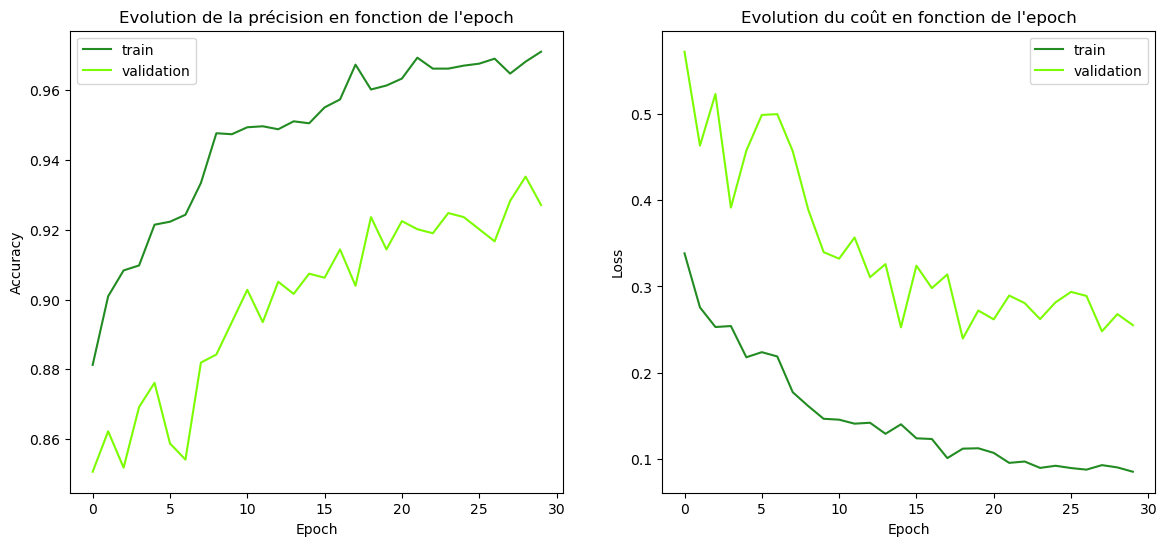

In [38]:
def plot_history():
    #Afficher la courbe de la fonction de coût et de précision en fonction de l'epoch
    training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    ax[0].plot(training_history['accuracy'], color='forestgreen')
    ax[0].plot(training_history['val_accuracy'], color='lawngreen')
    ax[0].set_title("Evolution de la précision en fonction de l'epoch")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(['train', 'validation'], loc='best');
    ax[1].plot(training_history['loss'], color='forestgreen')
    ax[1].plot(training_history['val_loss'], color='lawngreen')
    ax[1].set_title("Evolution du coût en fonction de l'epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend(['train', 'validation'], loc='best');

plot_history()
plt.show()

In [40]:
model.load_weights(checkpoint_filepath)

35/35 [==============================] - 12s 328ms/step
                           precision    recall  f1-score   support

              Black-grass       0.78      0.61      0.68        62
                 Charlock       0.99      0.97      0.98        90
                 Cleavers       0.94      0.97      0.96        67
         Common Chickweed       0.95      0.95      0.95       143
             Common wheat       0.96      0.84      0.90        51
                  Fat Hen       0.98      0.94      0.96       108
         Loose Silky-bent       0.84      0.93      0.88       152
                    Maize       0.98      0.96      0.97        51
        Scentless Mayweed       0.87      0.96      0.91       121
         Shepherd’s Purse       0.91      0.87      0.89        55
Small-flowered Cranesbill       0.99      0.95      0.97       115
               Sugar beet       0.96      0.97      0.96        93

                 accuracy                           0.93      1108
    

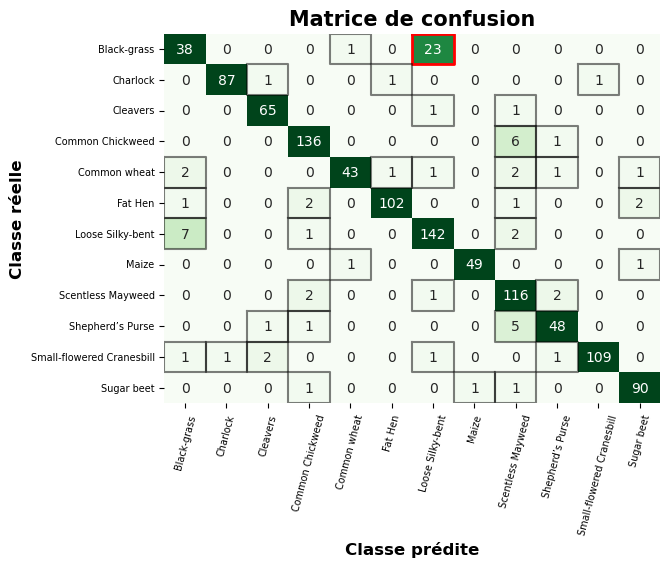

In [41]:
def show_metrics():
    y_true = test_iterator.classes #ou .labels
    y_pred = model.predict(test_iterator).argmax(axis=-1)
    #Evaluation du modèle : rapport de classification & matrice de confusion
    print(classification_report(y_true, y_pred, target_names = df.species.unique()))
    matrix = confusion_matrix(y_true, y_pred)
    classes = df.species.unique()
    sns.heatmap(matrix, annot=True,cmap="Greens", fmt = 'd',vmin=0,vmax=30,cbar=False)
    tick_marks = np.arange(0.5, len(classes), 1)
    plt.xticks(tick_marks, classes, rotation=75, fontsize = 7)
    plt.yticks(tick_marks, classes, rotation=0, fontsize = 7)
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        if (i!=j) and (matrix[i,j] !=0):
            if (matrix[i,j] > matrix.mean()):
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="red", linewidth=2)
            else:
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="k", alpha = 0.5)
    plt.ylabel("Classe réelle", fontweight = 'bold', fontsize = 12)
    plt.xlabel("Classe prédite", fontweight = 'bold', fontsize = 12)
    plt.title("Matrice de confusion", fontweight = 'extra bold', fontsize = 15);
    
show_metrics()
plt.show()

In [42]:
# Etape 2.3: Dé-freeze des 6 derniers blocs (11 et 12) du modèle de base
for layer in base_model.layers[98:]:
    layer.trainable = True
    
for i,layer in enumerate(base_model.layers):
    print(i,layer.name,"Trainable:",layer.trainable)

0 input_1 Trainable: False
1 Conv1 Trainable: False
2 bn_Conv1 Trainable: False
3 Conv1_relu Trainable: False
4 expanded_conv_depthwise Trainable: False
5 expanded_conv_depthwise_BN Trainable: False
6 expanded_conv_depthwise_relu Trainable: False
7 expanded_conv_project Trainable: False
8 expanded_conv_project_BN Trainable: False
9 block_1_expand Trainable: False
10 block_1_expand_BN Trainable: False
11 block_1_expand_relu Trainable: False
12 block_1_pad Trainable: False
13 block_1_depthwise Trainable: False
14 block_1_depthwise_BN Trainable: False
15 block_1_depthwise_relu Trainable: False
16 block_1_project Trainable: False
17 block_1_project_BN Trainable: False
18 block_2_expand Trainable: False
19 block_2_expand_BN Trainable: False
20 block_2_expand_relu Trainable: False
21 block_2_depthwise Trainable: False
22 block_2_depthwise_BN Trainable: False
23 block_2_depthwise_relu Trainable: False
24 block_2_project Trainable: False
25 block_2_project_BN Trainable: False
26 block_2_add Tr

In [43]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_DeFreeze','DeFreeze_3','best_weights.ckpt')
csvlogger_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_Defreeze','DeFreeze_3','training_history.csv')
loadweights_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_DeFreeze','DeFreeze_2','best_weights.ckpt')
lr=1.e-4
nb_epochs=30

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 0.1756 - accuracy: 0.9371
Epoch 1: val_accuracy improved from -inf to 0.88194, saving model to Models_training/MobileNetV2_SansSeg_SansZoom_DeFreeze/DeFreeze_3/best_weights.ckpt
110/110 [==============================] - 86s 767ms/step - loss: 0.1756 - accuracy: 0.9371 - val_loss: 0.4333 - val_accuracy: 0.8819 - lr: 1.0000e-04
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 0.1540 - accuracy: 0.9414
Epoch 2: val_accuracy improved from 0.88194 to 0.88542, saving model to Models_training/MobileNetV2_SansSeg_SansZoom_DeFreeze/DeFreeze_3/best_weights.ckpt
110/110 [==============================] - 81s 735ms/step - loss: 0.1540 - accuracy: 0.9414 - val_loss: 0.4472 - val_accuracy: 0.8854 - lr: 1.0000e-04
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.1783 - accuracy: 0.9414
Epoch 3: val_accuracy did not improve from 0.88542
110/110 [==============================] - 82s 743ms

110/110 [==============================] - 81s 733ms/step - loss: 0.0548 - accuracy: 0.9812 - val_loss: 0.2402 - val_accuracy: 0.9421 - lr: 3.1250e-06
Epoch 24/30
110/110 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9818
Epoch 24: val_accuracy did not improve from 0.94213
110/110 [==============================] - 80s 727ms/step - loss: 0.0589 - accuracy: 0.9818 - val_loss: 0.2828 - val_accuracy: 0.9329 - lr: 3.1250e-06
Epoch 25/30
110/110 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9815
Epoch 25: val_accuracy did not improve from 0.94213
110/110 [==============================] - 83s 750ms/step - loss: 0.0523 - accuracy: 0.9815 - val_loss: 0.2549 - val_accuracy: 0.9398 - lr: 3.1250e-06
Epoch 26/30
110/110 [==============================] - ETA: 0s - loss: 0.0569 - accuracy: 0.9804
Epoch 26: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 26: val_accuracy did not improve from 0.94213
110/110 [==============

In [44]:
# Calcul de la durée de l'entrainement
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")# Résultats de l'entrainement 

Durée de l'entraînement: 41.0 minutes.


In [45]:
training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
training_history.head()

,accuracy,loss,lr,val_accuracy,val_loss
epoch,,,,,
0,0.937091,0.175596,0.00010,0.881944,0.433321
1,0.941361,0.154003,0.00010,0.885417,0.447237
2,0.941361,0.178339,0.00010,0.868056,0.609565
3,0.942784,0.158443,0.00010,0.884259,0.563603
4,0.961287,0.116860,0.00005,0.896991,0.390582


In [46]:
# Trouve l'index de la ligne avec la valeur maximale de val_accuracy
max_val_accuracy_idx = training_history['val_accuracy'].idxmax()

# Sélectionne la ligne correspondante et affiche toutes les colonnes
row_with_max_val_accuracy = training_history.loc[max_val_accuracy_idx]
print('Valeurs Max')
print(row_with_max_val_accuracy)

# Trouve l'index de la ligne avec la valeur min de val_accuracy
min_val_accuracy_idx = training_history['val_accuracy'].idxmin()

# Sélectionne la ligne correspondante et affiche toutes les colonnes
row_with_min_val_accuracy = training_history.loc[min_val_accuracy_idx]
print('Valeurs Min')
print(row_with_min_val_accuracy)

column_means = training_history.mean()
print('Valeurs Moyennes')
print(column_means)

Valeurs Max
accuracy        0.981213
loss            0.054818
lr              0.000003
val_accuracy    0.942130
val_loss        0.240197
Name: 22, dtype: float64
Valeurs Min
accuracy        0.941361
loss            0.178339
lr              0.000100
val_accuracy    0.868056
val_loss        0.609565
Name: 2, dtype: float64
Valeurs Moyennes
accuracy        0.970416
loss            0.083764
lr              0.000031
val_accuracy    0.918441
val_loss        0.318123
dtype: float64


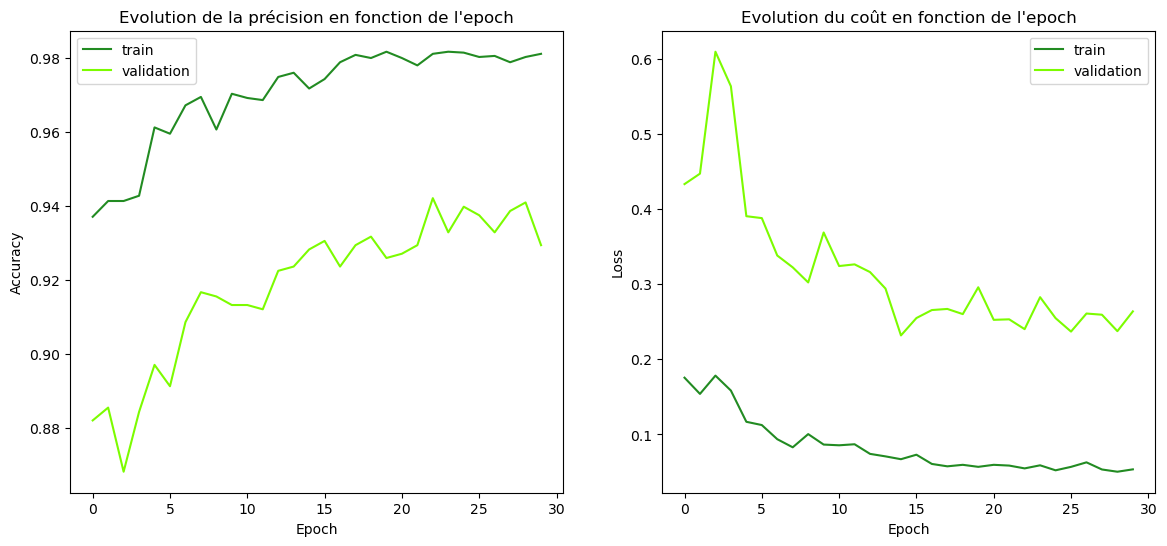

In [47]:
def plot_history():
    #Afficher la courbe de la fonction de coût et de précision en fonction de l'epoch
    training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    ax[0].plot(training_history['accuracy'], color='forestgreen')
    ax[0].plot(training_history['val_accuracy'], color='lawngreen')
    ax[0].set_title("Evolution de la précision en fonction de l'epoch")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(['train', 'validation'], loc='best');
    ax[1].plot(training_history['loss'], color='forestgreen')
    ax[1].plot(training_history['val_loss'], color='lawngreen')
    ax[1].set_title("Evolution du coût en fonction de l'epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend(['train', 'validation'], loc='best');

plot_history()
plt.show()

In [48]:
model.load_weights(checkpoint_filepath)

35/35 [==============================] - 11s 309ms/step
                           precision    recall  f1-score   support

              Black-grass       0.83      0.65      0.73        62
                 Charlock       1.00      0.98      0.99        90
                 Cleavers       0.99      0.99      0.99        67
         Common Chickweed       0.95      0.99      0.97       143
             Common wheat       1.00      0.92      0.96        51
                  Fat Hen       0.99      0.94      0.97       108
         Loose Silky-bent       0.85      0.95      0.90       152
                    Maize       1.00      0.98      0.99        51
        Scentless Mayweed       0.91      0.94      0.93       121
         Shepherd’s Purse       0.93      0.91      0.92        55
Small-flowered Cranesbill       0.99      0.97      0.98       115
               Sugar beet       0.96      0.99      0.97        93

                 accuracy                           0.94      1108
    

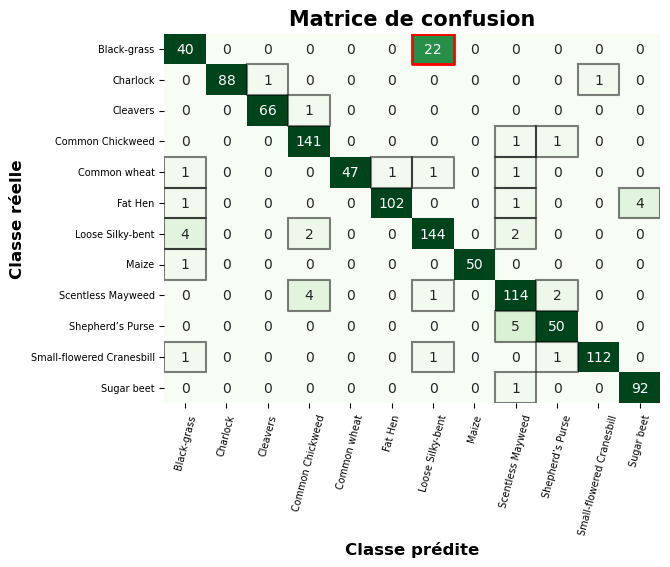

In [49]:
def show_metrics():
    y_true = test_iterator.classes #ou .labels
    y_pred = model.predict(test_iterator).argmax(axis=-1)
    #Evaluation du modèle : rapport de classification & matrice de confusion
    print(classification_report(y_true, y_pred, target_names = df.species.unique()))
    matrix = confusion_matrix(y_true, y_pred)
    classes = df.species.unique()
    sns.heatmap(matrix, annot=True,cmap="Greens", fmt = 'd',vmin=0,vmax=30,cbar=False)
    tick_marks = np.arange(0.5, len(classes), 1)
    plt.xticks(tick_marks, classes, rotation=75, fontsize = 7)
    plt.yticks(tick_marks, classes, rotation=0, fontsize = 7)
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        if (i!=j) and (matrix[i,j] !=0):
            if (matrix[i,j] > matrix.mean()):
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="red", linewidth=2)
            else:
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="k", alpha = 0.5)
    plt.ylabel("Classe réelle", fontweight = 'bold', fontsize = 12)
    plt.xlabel("Classe prédite", fontweight = 'bold', fontsize = 12)
    plt.title("Matrice de confusion", fontweight = 'extra bold', fontsize = 15);
    
show_metrics()
plt.show()

In [50]:
# Etape 2.4: Dé-freeze des 8 derniers blocs (9 et 10) du modèle de base
for layer in base_model.layers[81:]:
    layer.trainable = True
    
for i,layer in enumerate(base_model.layers):
    print(i,layer.name,"Trainable:",layer.trainable)

0 input_1 Trainable: False
1 Conv1 Trainable: False
2 bn_Conv1 Trainable: False
3 Conv1_relu Trainable: False
4 expanded_conv_depthwise Trainable: False
5 expanded_conv_depthwise_BN Trainable: False
6 expanded_conv_depthwise_relu Trainable: False
7 expanded_conv_project Trainable: False
8 expanded_conv_project_BN Trainable: False
9 block_1_expand Trainable: False
10 block_1_expand_BN Trainable: False
11 block_1_expand_relu Trainable: False
12 block_1_pad Trainable: False
13 block_1_depthwise Trainable: False
14 block_1_depthwise_BN Trainable: False
15 block_1_depthwise_relu Trainable: False
16 block_1_project Trainable: False
17 block_1_project_BN Trainable: False
18 block_2_expand Trainable: False
19 block_2_expand_BN Trainable: False
20 block_2_expand_relu Trainable: False
21 block_2_depthwise Trainable: False
22 block_2_depthwise_BN Trainable: False
23 block_2_depthwise_relu Trainable: False
24 block_2_project Trainable: False
25 block_2_project_BN Trainable: False
26 block_2_add Tr

In [51]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_DeFreeze','DeFreeze_4','best_weights.ckpt')
csvlogger_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_Defreeze','DeFreeze_4','training_history.csv')
loadweights_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_DeFreeze','DeFreeze_3','best_weights.ckpt')
lr=1.e-4
nb_epochs=30

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 0.1138 - accuracy: 0.9567
Epoch 1: val_accuracy improved from -inf to 0.91319, saving model to Models_training/MobileNetV2_SansSeg_SansZoom_DeFreeze/DeFreeze_4/best_weights.ckpt
110/110 [==============================] - 93s 832ms/step - loss: 0.1138 - accuracy: 0.9567 - val_loss: 0.3299 - val_accuracy: 0.9132 - lr: 1.0000e-04
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 0.1298 - accuracy: 0.9567
Epoch 2: val_accuracy improved from 0.91319 to 0.91898, saving model to Models_training/MobileNetV2_SansSeg_SansZoom_DeFreeze/DeFreeze_4/best_weights.ckpt
110/110 [==============================] - 90s 819ms/step - loss: 0.1298 - accuracy: 0.9567 - val_loss: 0.3355 - val_accuracy: 0.9190 - lr: 1.0000e-04
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.1401 - accuracy: 0.9533
Epoch 3: val_accuracy did not improve from 0.91898
110/110 [==============================] - 91s 828ms

Epoch 25/30
110/110 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.9861
Epoch 25: val_accuracy did not improve from 0.94097
110/110 [==============================] - 90s 815ms/step - loss: 0.0418 - accuracy: 0.9861 - val_loss: 0.2787 - val_accuracy: 0.9387 - lr: 1.5625e-06
Epoch 26/30
110/110 [==============================] - ETA: 0s - loss: 0.0383 - accuracy: 0.9869
Epoch 26: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 26: val_accuracy did not improve from 0.94097
110/110 [==============================] - 100s 911ms/step - loss: 0.0383 - accuracy: 0.9869 - val_loss: 0.2218 - val_accuracy: 0.9375 - lr: 1.5625e-06
Epoch 27/30
110/110 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9895
Epoch 27: val_accuracy did not improve from 0.94097
110/110 [==============================] - 89s 811ms/step - loss: 0.0333 - accuracy: 0.9895 - val_loss: 0.2641 - val_accuracy: 0.9294 - lr: 7.8125e-07
Epoch 28/30
110/110 [=

In [52]:
# Calcul de la durée de l'entrainement
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")# Résultats de l'entrainement 

Durée de l'entraînement: 45.0 minutes.


In [53]:
training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
training_history.head()

,accuracy,loss,lr,val_accuracy,val_loss
epoch,,,,,
0,0.956732,0.113828,0.00010,0.913194,0.329869
1,0.956732,0.129770,0.00010,0.918981,0.335524
2,0.953316,0.140065,0.00010,0.859954,0.531182
3,0.960717,0.111003,0.00010,0.907407,0.375579
4,0.973242,0.075502,0.00005,0.915509,0.313041


In [54]:
# Trouve l'index de la ligne avec la valeur maximale de val_accuracy
max_val_accuracy_idx = training_history['val_accuracy'].idxmax()

# Sélectionne la ligne correspondante et affiche toutes les colonnes
row_with_max_val_accuracy = training_history.loc[max_val_accuracy_idx]
print('Valeurs Max')
print(row_with_max_val_accuracy)

# Trouve l'index de la ligne avec la valeur min de val_accuracy
min_val_accuracy_idx = training_history['val_accuracy'].idxmin()

# Sélectionne la ligne correspondante et affiche toutes les colonnes
row_with_min_val_accuracy = training_history.loc[min_val_accuracy_idx]
print('Valeurs Min')
print(row_with_min_val_accuracy)

column_means = training_history.mean()
print('Valeurs Moyennes')
print(column_means)

Valeurs Max
accuracy        0.985198
loss            0.042236
lr              0.000006
val_accuracy    0.940972
val_loss        0.231510
Name: 16, dtype: float64
Valeurs Min
accuracy        0.953316
loss            0.140065
lr              0.000100
val_accuracy    0.859954
val_loss        0.531182
Name: 2, dtype: float64
Valeurs Moyennes
accuracy        0.979998
loss            0.058731
lr              0.000027
val_accuracy    0.925656
val_loss        0.288963
dtype: float64


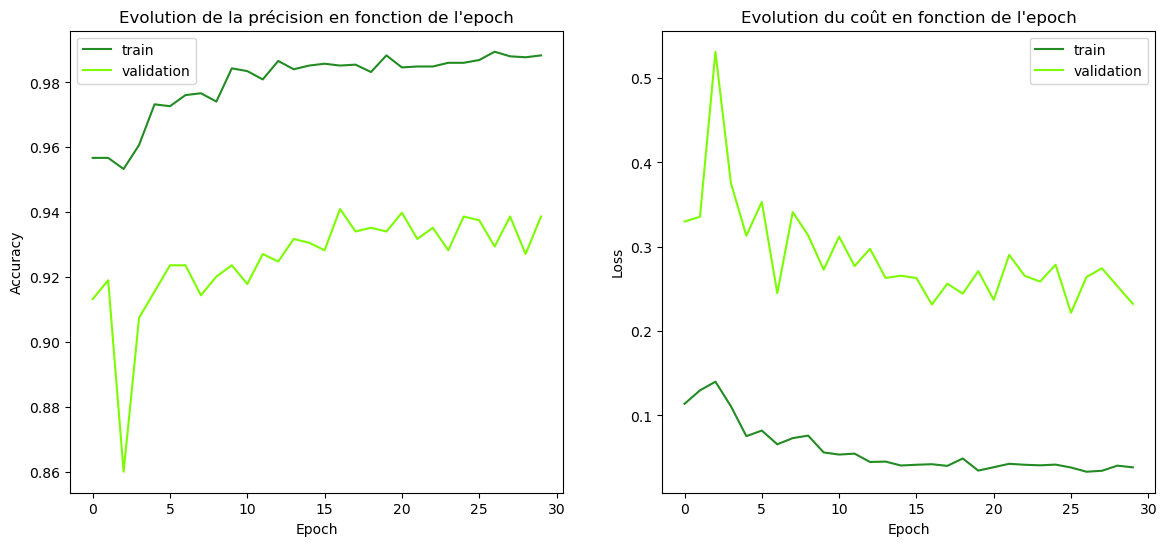

In [55]:
def plot_history():
    #Afficher la courbe de la fonction de coût et de précision en fonction de l'epoch
    training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    ax[0].plot(training_history['accuracy'], color='forestgreen')
    ax[0].plot(training_history['val_accuracy'], color='lawngreen')
    ax[0].set_title("Evolution de la précision en fonction de l'epoch")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(['train', 'validation'], loc='best');
    ax[1].plot(training_history['loss'], color='forestgreen')
    ax[1].plot(training_history['val_loss'], color='lawngreen')
    ax[1].set_title("Evolution du coût en fonction de l'epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend(['train', 'validation'], loc='best');

plot_history()
plt.show()

In [56]:
model.load_weights(checkpoint_filepath)

35/35 [==============================] - 12s 333ms/step
                           precision    recall  f1-score   support

              Black-grass       0.70      0.69      0.70        62
                 Charlock       1.00      0.97      0.98        90
                 Cleavers       1.00      0.97      0.98        67
         Common Chickweed       0.97      0.97      0.97       143
             Common wheat       0.96      0.90      0.93        51
                  Fat Hen       0.95      0.98      0.97       108
         Loose Silky-bent       0.88      0.91      0.90       152
                    Maize       0.98      0.98      0.98        51
        Scentless Mayweed       0.93      0.93      0.93       121
         Shepherd’s Purse       0.94      0.91      0.93        55
Small-flowered Cranesbill       0.99      0.98      0.99       115
               Sugar beet       0.96      0.97      0.96        93

                 accuracy                           0.94      1108
    

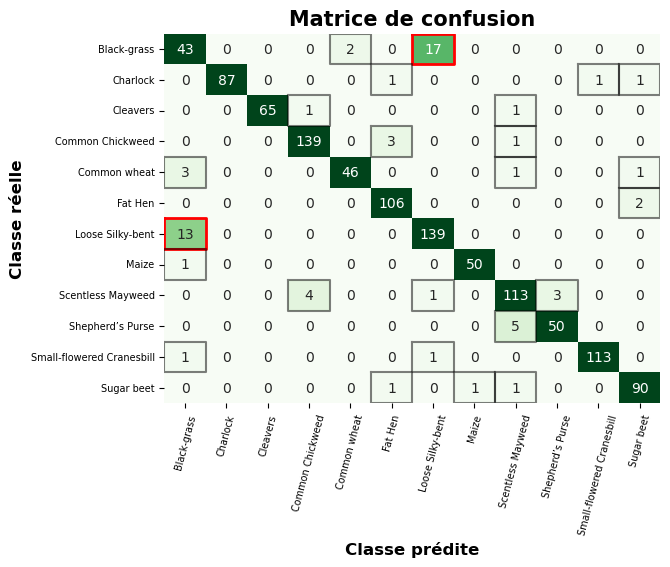

In [57]:
def show_metrics():
    y_true = test_iterator.classes #ou .labels
    y_pred = model.predict(test_iterator).argmax(axis=-1)
    #Evaluation du modèle : rapport de classification & matrice de confusion
    print(classification_report(y_true, y_pred, target_names = df.species.unique()))
    matrix = confusion_matrix(y_true, y_pred)
    classes = df.species.unique()
    sns.heatmap(matrix, annot=True,cmap="Greens", fmt = 'd',vmin=0,vmax=30,cbar=False)
    tick_marks = np.arange(0.5, len(classes), 1)
    plt.xticks(tick_marks, classes, rotation=75, fontsize = 7)
    plt.yticks(tick_marks, classes, rotation=0, fontsize = 7)
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        if (i!=j) and (matrix[i,j] !=0):
            if (matrix[i,j] > matrix.mean()):
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="red", linewidth=2)
            else:
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="k", alpha = 0.5)
    plt.ylabel("Classe réelle", fontweight = 'bold', fontsize = 12)
    plt.xlabel("Classe prédite", fontweight = 'bold', fontsize = 12)
    plt.title("Matrice de confusion", fontweight = 'extra bold', fontsize = 15);
    
show_metrics()
plt.show()

In [58]:
# Etape 2.5: Dé-freeze des 10 derniers blocs (7 et 8) du modèle de base
for layer in base_model.layers[63:]:
    layer.trainable = True
    
for i,layer in enumerate(base_model.layers):
    print(i,layer.name,"Trainable:",layer.trainable)

0 input_1 Trainable: False
1 Conv1 Trainable: False
2 bn_Conv1 Trainable: False
3 Conv1_relu Trainable: False
4 expanded_conv_depthwise Trainable: False
5 expanded_conv_depthwise_BN Trainable: False
6 expanded_conv_depthwise_relu Trainable: False
7 expanded_conv_project Trainable: False
8 expanded_conv_project_BN Trainable: False
9 block_1_expand Trainable: False
10 block_1_expand_BN Trainable: False
11 block_1_expand_relu Trainable: False
12 block_1_pad Trainable: False
13 block_1_depthwise Trainable: False
14 block_1_depthwise_BN Trainable: False
15 block_1_depthwise_relu Trainable: False
16 block_1_project Trainable: False
17 block_1_project_BN Trainable: False
18 block_2_expand Trainable: False
19 block_2_expand_BN Trainable: False
20 block_2_expand_relu Trainable: False
21 block_2_depthwise Trainable: False
22 block_2_depthwise_BN Trainable: False
23 block_2_depthwise_relu Trainable: False
24 block_2_project Trainable: False
25 block_2_project_BN Trainable: False
26 block_2_add Tr

In [59]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_DeFreeze','DeFreeze_5','best_weights.ckpt')
csvlogger_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_Defreeze','DeFreeze_5','training_history.csv')
loadweights_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_DeFreeze','DeFreeze_4','best_weights.ckpt')
lr=1.e-4
nb_epochs=30

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 0.1177 - accuracy: 0.9601
Epoch 1: val_accuracy improved from -inf to 0.90856, saving model to Models_training/MobileNetV2_SansSeg_SansZoom_DeFreeze/DeFreeze_5/best_weights.ckpt
110/110 [==============================] - 97s 862ms/step - loss: 0.1177 - accuracy: 0.9601 - val_loss: 0.3633 - val_accuracy: 0.9086 - lr: 1.0000e-04
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 0.1045 - accuracy: 0.9624
Epoch 2: val_accuracy improved from 0.90856 to 0.91088, saving model to Models_training/MobileNetV2_SansSeg_SansZoom_DeFreeze/DeFreeze_5/best_weights.ckpt
110/110 [==============================] - 94s 853ms/step - loss: 0.1045 - accuracy: 0.9624 - val_loss: 0.3076 - val_accuracy: 0.9109 - lr: 1.0000e-04
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.0943 - accuracy: 0.9661
Epoch 3: val_accuracy did not improve from 0.91088
110/110 [==============================] - 94s 857ms

110/110 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9920
Epoch 24: val_accuracy did not improve from 0.94792
110/110 [==============================] - 94s 856ms/step - loss: 0.0211 - accuracy: 0.9920 - val_loss: 0.2536 - val_accuracy: 0.9433 - lr: 3.1250e-06
Epoch 25/30
110/110 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9920
Epoch 25: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 25: val_accuracy did not improve from 0.94792
110/110 [==============================] - 94s 855ms/step - loss: 0.0207 - accuracy: 0.9920 - val_loss: 0.2718 - val_accuracy: 0.9410 - lr: 3.1250e-06
Epoch 26/30
110/110 [==============================] - ETA: 0s - loss: 0.0236 - accuracy: 0.9929
Epoch 26: val_accuracy did not improve from 0.94792
110/110 [==============================] - 94s 856ms/step - loss: 0.0236 - accuracy: 0.9929 - val_loss: 0.2595 - val_accuracy: 0.9456 - lr: 1.5625e-06
Epoch 27/30
110/110 [==============

In [60]:
# Calcul de la durée de l'entrainement
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")# Résultats de l'entrainement 

Durée de l'entraînement: 47.0 minutes.


In [61]:
training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
training_history.head()

,accuracy,loss,lr,val_accuracy,val_loss
epoch,,,,,
0,0.960148,0.117745,0.00010,0.908565,0.363319
1,0.962425,0.104549,0.00010,0.910880,0.307642
2,0.966126,0.094280,0.00010,0.906250,0.384622
3,0.966695,0.098111,0.00010,0.853009,0.600533
4,0.974666,0.073912,0.00005,0.902778,0.393287


In [62]:
# Trouve l'index de la ligne avec la valeur maximale de val_accuracy
max_val_accuracy_idx = training_history['val_accuracy'].idxmax()

# Sélectionne la ligne correspondante et affiche toutes les colonnes
row_with_max_val_accuracy = training_history.loc[max_val_accuracy_idx]
print('Valeurs Max')
print(row_with_max_val_accuracy)

# Trouve l'index de la ligne avec la valeur min de val_accuracy
min_val_accuracy_idx = training_history['val_accuracy'].idxmin()

# Sélectionne la ligne correspondante et affiche toutes les colonnes
row_with_min_val_accuracy = training_history.loc[min_val_accuracy_idx]
print('Valeurs Min')
print(row_with_min_val_accuracy)

column_means = training_history.mean()
print('Valeurs Moyennes')
print(column_means)

Valeurs Max
accuracy        0.991176
loss            0.024534
lr              0.000006
val_accuracy    0.947917
val_loss        0.236401
Name: 20, dtype: float64
Valeurs Min
accuracy        0.966695
loss            0.098111
lr              0.000100
val_accuracy    0.853009
val_loss        0.600533
Name: 3, dtype: float64
Valeurs Moyennes
accuracy        0.984553
loss            0.043871
lr              0.000033
val_accuracy    0.929938
val_loss        0.299678
dtype: float64


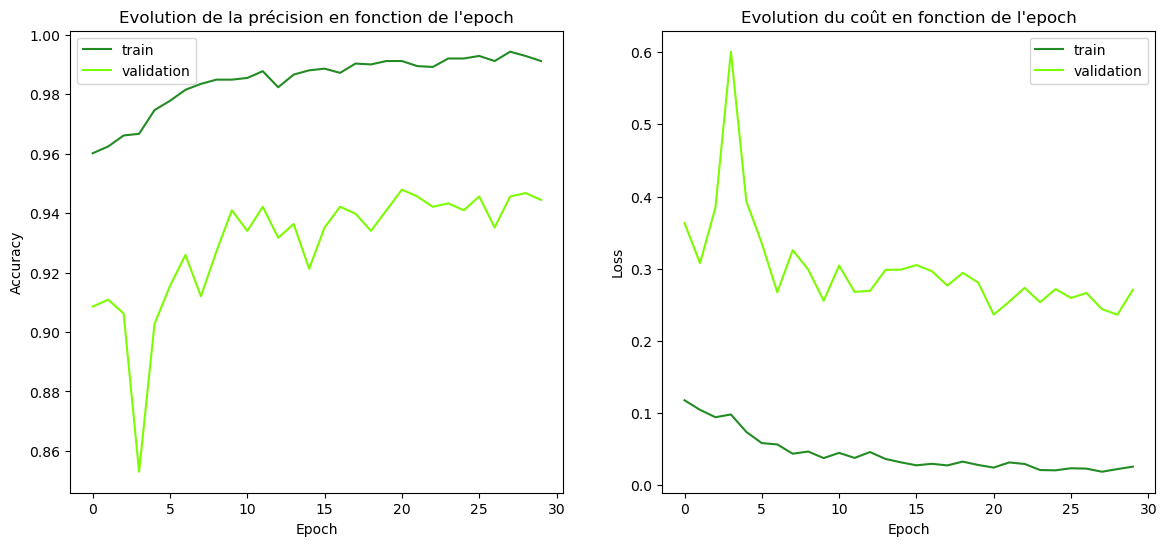

In [63]:
def plot_history():
    #Afficher la courbe de la fonction de coût et de précision en fonction de l'epoch
    training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    ax[0].plot(training_history['accuracy'], color='forestgreen')
    ax[0].plot(training_history['val_accuracy'], color='lawngreen')
    ax[0].set_title("Evolution de la précision en fonction de l'epoch")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(['train', 'validation'], loc='best');
    ax[1].plot(training_history['loss'], color='forestgreen')
    ax[1].plot(training_history['val_loss'], color='lawngreen')
    ax[1].set_title("Evolution du coût en fonction de l'epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend(['train', 'validation'], loc='best');

plot_history()
plt.show()

In [64]:
model.load_weights(checkpoint_filepath)

35/35 [==============================] - 12s 322ms/step
                           precision    recall  f1-score   support

              Black-grass       0.76      0.61      0.68        62
                 Charlock       1.00      0.99      0.99        90
                 Cleavers       1.00      0.97      0.98        67
         Common Chickweed       0.97      0.99      0.98       143
             Common wheat       0.98      0.92      0.95        51
                  Fat Hen       1.00      0.96      0.98       108
         Loose Silky-bent       0.86      0.95      0.90       152
                    Maize       0.98      0.98      0.98        51
        Scentless Mayweed       0.93      0.98      0.96       121
         Shepherd’s Purse       1.00      0.91      0.95        55
Small-flowered Cranesbill       1.00      0.97      0.99       115
               Sugar beet       0.94      0.99      0.96        93

                 accuracy                           0.95      1108
    

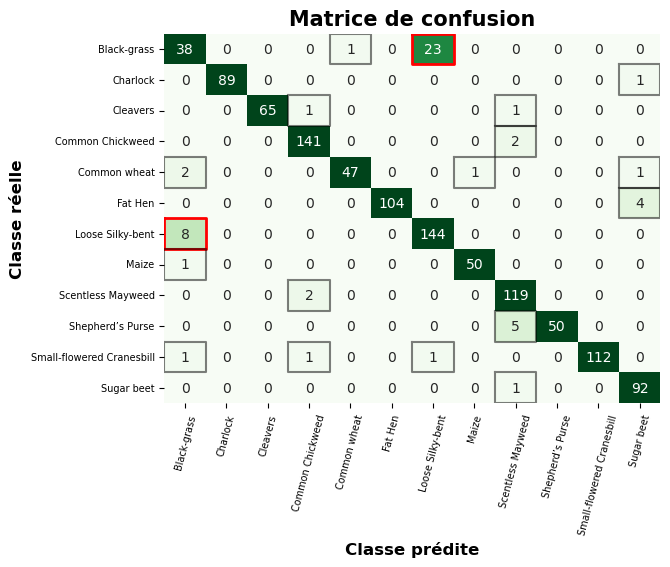

In [65]:
def show_metrics():
    y_true = test_iterator.classes #ou .labels
    y_pred = model.predict(test_iterator).argmax(axis=-1)
    #Evaluation du modèle : rapport de classification & matrice de confusion
    print(classification_report(y_true, y_pred, target_names = df.species.unique()))
    matrix = confusion_matrix(y_true, y_pred)
    classes = df.species.unique()
    sns.heatmap(matrix, annot=True,cmap="Greens", fmt = 'd',vmin=0,vmax=30,cbar=False)
    tick_marks = np.arange(0.5, len(classes), 1)
    plt.xticks(tick_marks, classes, rotation=75, fontsize = 7)
    plt.yticks(tick_marks, classes, rotation=0, fontsize = 7)
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        if (i!=j) and (matrix[i,j] !=0):
            if (matrix[i,j] > matrix.mean()):
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="red", linewidth=2)
            else:
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="k", alpha = 0.5)
    plt.ylabel("Classe réelle", fontweight = 'bold', fontsize = 12)
    plt.xlabel("Classe prédite", fontweight = 'bold', fontsize = 12)
    plt.title("Matrice de confusion", fontweight = 'extra bold', fontsize = 15);
    
show_metrics()
plt.show()

In [66]:
# Etape 2.6: Dé-freeze des 12 derniers blocs (5 et 6) du modèle de base
for layer in base_model.layers[54:]:
    layer.trainable = True
    
for i,layer in enumerate(base_model.layers):
    print(i,layer.name,"Trainable:",layer.trainable)

0 input_1 Trainable: False
1 Conv1 Trainable: False
2 bn_Conv1 Trainable: False
3 Conv1_relu Trainable: False
4 expanded_conv_depthwise Trainable: False
5 expanded_conv_depthwise_BN Trainable: False
6 expanded_conv_depthwise_relu Trainable: False
7 expanded_conv_project Trainable: False
8 expanded_conv_project_BN Trainable: False
9 block_1_expand Trainable: False
10 block_1_expand_BN Trainable: False
11 block_1_expand_relu Trainable: False
12 block_1_pad Trainable: False
13 block_1_depthwise Trainable: False
14 block_1_depthwise_BN Trainable: False
15 block_1_depthwise_relu Trainable: False
16 block_1_project Trainable: False
17 block_1_project_BN Trainable: False
18 block_2_expand Trainable: False
19 block_2_expand_BN Trainable: False
20 block_2_expand_relu Trainable: False
21 block_2_depthwise Trainable: False
22 block_2_depthwise_BN Trainable: False
23 block_2_depthwise_relu Trainable: False
24 block_2_project Trainable: False
25 block_2_project_BN Trainable: False
26 block_2_add Tr

In [68]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_DeFreeze','DeFreeze_6','best_weights.ckpt')
csvlogger_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_Defreeze','DeFreeze_6','training_history.csv')
loadweights_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_DeFreeze','DeFreeze_5','best_weights.ckpt')
lr=1.e-4
nb_epochs=30

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9758
Epoch 1: val_accuracy improved from -inf to 0.92940, saving model to Models_training/MobileNetV2_SansSeg_SansZoom_DeFreeze/DeFreeze_6/best_weights.ckpt
110/110 [==============================] - 109s 973ms/step - loss: 0.0718 - accuracy: 0.9758 - val_loss: 0.2844 - val_accuracy: 0.9294 - lr: 1.0000e-04
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 0.9778
Epoch 2: val_accuracy did not improve from 0.92940
110/110 [==============================] - 99s 902ms/step - loss: 0.0668 - accuracy: 0.9778 - val_loss: 0.4546 - val_accuracy: 0.9190 - lr: 1.0000e-04
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.0674 - accuracy: 0.9792
Epoch 3: val_accuracy did not improve from 0.92940
110/110 [==============================] - 97s 876ms/step - loss: 0.0674 - accuracy: 0.9792 - val_loss: 0.5569 - val_accuracy: 0.9016 - lr: 1.0000e-04
Epoc

110/110 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9957
Epoch 25: val_accuracy improved from 0.94907 to 0.95255, saving model to Models_training/MobileNetV2_SansSeg_SansZoom_DeFreeze/DeFreeze_6/best_weights.ckpt
110/110 [==============================] - 100s 905ms/step - loss: 0.0146 - accuracy: 0.9957 - val_loss: 0.2305 - val_accuracy: 0.9525 - lr: 7.8125e-07
Epoch 26/30
110/110 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9954
Epoch 26: val_accuracy did not improve from 0.95255
110/110 [==============================] - 98s 885ms/step - loss: 0.0144 - accuracy: 0.9954 - val_loss: 0.2806 - val_accuracy: 0.9410 - lr: 7.8125e-07
Epoch 27/30
110/110 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9940
Epoch 27: val_accuracy did not improve from 0.95255
110/110 [==============================] - 100s 903ms/step - loss: 0.0161 - accuracy: 0.9940 - val_loss: 0.2307 - val_accuracy: 0.9456 - lr: 7.8125e-07
Epoch 

In [69]:
# Calcul de la durée de l'entrainement
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")# Résultats de l'entrainement 

Durée de l'entraînement: 49.0 minutes.


In [70]:
training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
training_history.head()

,accuracy,loss,lr,val_accuracy,val_loss
epoch,,,,,
0,0.975804,0.071819,0.00010,0.929398,0.284427
1,0.977797,0.066763,0.00010,0.918981,0.454560
2,0.979220,0.067377,0.00010,0.901620,0.556889
3,0.977512,0.075467,0.00010,0.847222,0.833019
4,0.983775,0.048483,0.00005,0.918981,0.370967


In [71]:
# Trouve l'index de la ligne avec la valeur maximale de val_accuracy
max_val_accuracy_idx = training_history['val_accuracy'].idxmax()

# Sélectionne la ligne correspondante et affiche toutes les colonnes
row_with_max_val_accuracy = training_history.loc[max_val_accuracy_idx]
print('Valeurs Max')
print(row_with_max_val_accuracy)

# Trouve l'index de la ligne avec la valeur min de val_accuracy
min_val_accuracy_idx = training_history['val_accuracy'].idxmin()

# Sélectionne la ligne correspondante et affiche toutes les colonnes
row_with_min_val_accuracy = training_history.loc[min_val_accuracy_idx]
print('Valeurs Min')
print(row_with_min_val_accuracy)

column_means = training_history.mean()
print('Valeurs Moyennes')
print(column_means)

Valeurs Max
accuracy        9.957302e-01
loss            1.461144e-02
lr              7.812500e-07
val_accuracy    9.525463e-01
val_loss        2.304999e-01
Name: 24, dtype: float64
Valeurs Min
accuracy        0.977512
loss            0.075467
lr              0.000100
val_accuracy    0.847222
val_loss        0.833019
Name: 3, dtype: float64
Valeurs Moyennes
accuracy        0.990511
loss            0.028753
lr              0.000025
val_accuracy    0.933912
val_loss        0.319651
dtype: float64


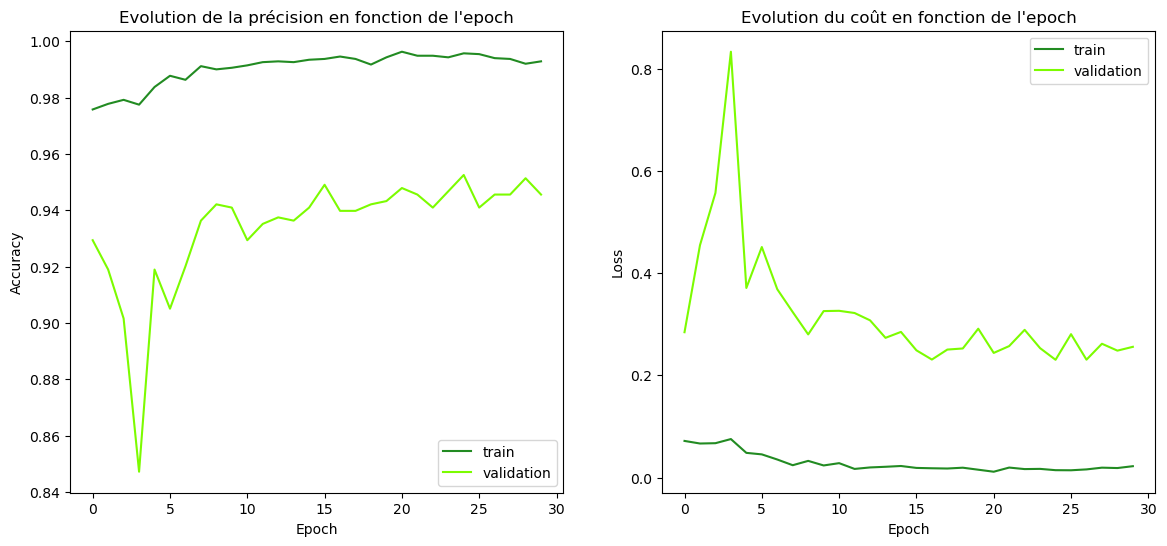

In [72]:
# Tracé des courbes de précision et de cout en fonction de l'epoch

def plot_history():
    #Afficher la courbe de la fonction de coût et de précision en fonction de l'epoch
    training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    ax[0].plot(training_history['accuracy'], color='forestgreen')
    ax[0].plot(training_history['val_accuracy'], color='lawngreen')
    ax[0].set_title("Evolution de la précision en fonction de l'epoch")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(['train', 'validation'], loc='best');
    ax[1].plot(training_history['loss'], color='forestgreen')
    ax[1].plot(training_history['val_loss'], color='lawngreen')
    ax[1].set_title("Evolution du coût en fonction de l'epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend(['train', 'validation'], loc='best');

plot_history()
plt.show()

In [73]:
model.load_weights(checkpoint_filepath)

35/35 [==============================] - 11s 302ms/step
                           precision    recall  f1-score   support

              Black-grass       0.74      0.65      0.69        62
                 Charlock       0.99      0.98      0.98        90
                 Cleavers       1.00      0.97      0.98        67
         Common Chickweed       0.97      0.99      0.98       143
             Common wheat       0.96      0.92      0.94        51
                  Fat Hen       0.99      0.96      0.98       108
         Loose Silky-bent       0.86      0.93      0.90       152
                    Maize       0.98      0.94      0.96        51
        Scentless Mayweed       0.95      0.97      0.96       121
         Shepherd’s Purse       0.94      0.93      0.94        55
Small-flowered Cranesbill       0.99      0.97      0.98       115
               Sugar beet       0.94      0.97      0.95        93

                 accuracy                           0.94      1108
    

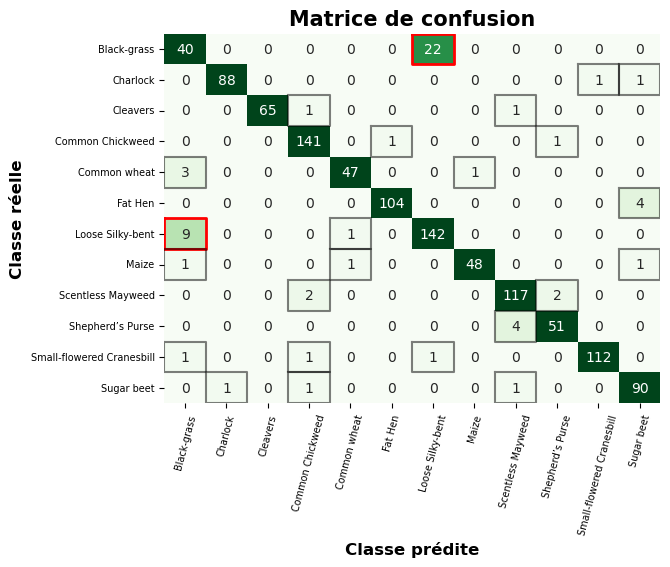

In [74]:
# Rapport de cllassification et matrice de confusion
def show_metrics():
    y_true = test_iterator.classes #ou .labels
    y_pred = model.predict(test_iterator).argmax(axis=-1)
    #Evaluation du modèle : rapport de classification & matrice de confusion
    print(classification_report(y_true, y_pred, target_names = df.species.unique()))
    matrix = confusion_matrix(y_true, y_pred)
    classes = df.species.unique()
    sns.heatmap(matrix, annot=True,cmap="Greens", fmt = 'd',vmin=0,vmax=30,cbar=False)
    tick_marks = np.arange(0.5, len(classes), 1)
    plt.xticks(tick_marks, classes, rotation=75, fontsize = 7)
    plt.yticks(tick_marks, classes, rotation=0, fontsize = 7)
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        if (i!=j) and (matrix[i,j] !=0):
            if (matrix[i,j] > matrix.mean()):
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="red", linewidth=2)
            else:
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="k", alpha = 0.5)
    plt.ylabel("Classe réelle", fontweight = 'bold', fontsize = 12)
    plt.xlabel("Classe prédite", fontweight = 'bold', fontsize = 12)
    plt.title("Matrice de confusion", fontweight = 'extra bold', fontsize = 15);
    
show_metrics()
plt.show()

In [75]:
# Etape 2.7: Dé-freeze des 14 derniers blocs (3 et 4) du modèle de base
for layer in base_model.layers[27:]:
    layer.trainable = True
    
for i,layer in enumerate(base_model.layers):
    print(i,layer.name,"Trainable:",layer.trainable)

0 input_1 Trainable: False
1 Conv1 Trainable: False
2 bn_Conv1 Trainable: False
3 Conv1_relu Trainable: False
4 expanded_conv_depthwise Trainable: False
5 expanded_conv_depthwise_BN Trainable: False
6 expanded_conv_depthwise_relu Trainable: False
7 expanded_conv_project Trainable: False
8 expanded_conv_project_BN Trainable: False
9 block_1_expand Trainable: False
10 block_1_expand_BN Trainable: False
11 block_1_expand_relu Trainable: False
12 block_1_pad Trainable: False
13 block_1_depthwise Trainable: False
14 block_1_depthwise_BN Trainable: False
15 block_1_depthwise_relu Trainable: False
16 block_1_project Trainable: False
17 block_1_project_BN Trainable: False
18 block_2_expand Trainable: False
19 block_2_expand_BN Trainable: False
20 block_2_expand_relu Trainable: False
21 block_2_depthwise Trainable: False
22 block_2_depthwise_BN Trainable: False
23 block_2_depthwise_relu Trainable: False
24 block_2_project Trainable: False
25 block_2_project_BN Trainable: False
26 block_2_add Tr

In [76]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_DeFreeze','DeFreeze_7','best_weights.ckpt')
csvlogger_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_Defreeze','DeFreeze_7','training_history.csv')
loadweights_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_DeFreeze','DeFreeze_6','best_weights.ckpt')
lr=1.e-4
nb_epochs=30

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 0.0650 - accuracy: 0.9806
Epoch 1: val_accuracy improved from -inf to 0.91898, saving model to Models_training/MobileNetV2_SansSeg_SansZoom_DeFreeze/DeFreeze_7/best_weights.ckpt
110/110 [==============================] - 115s 1s/step - loss: 0.0650 - accuracy: 0.9806 - val_loss: 0.3305 - val_accuracy: 0.9190 - lr: 1.0000e-04
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 0.0731 - accuracy: 0.9767
Epoch 2: val_accuracy improved from 0.91898 to 0.93634, saving model to Models_training/MobileNetV2_SansSeg_SansZoom_DeFreeze/DeFreeze_7/best_weights.ckpt
110/110 [==============================] - 109s 991ms/step - loss: 0.0731 - accuracy: 0.9767 - val_loss: 0.2780 - val_accuracy: 0.9363 - lr: 1.0000e-04
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.0568 - accuracy: 0.9821
Epoch 3: val_accuracy did not improve from 0.93634
110/110 [==============================] - 116s 1s/st

110/110 [==============================] - 102s 925ms/step - loss: 0.0132 - accuracy: 0.9957 - val_loss: 0.2602 - val_accuracy: 0.9502 - lr: 1.5625e-06
Epoch 25/30
110/110 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9949
Epoch 25: val_accuracy did not improve from 0.95833
110/110 [==============================] - 102s 923ms/step - loss: 0.0162 - accuracy: 0.9949 - val_loss: 0.2462 - val_accuracy: 0.9560 - lr: 1.5625e-06
Epoch 26/30
110/110 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9943
Epoch 26: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 26: val_accuracy did not improve from 0.95833
110/110 [==============================] - 102s 922ms/step - loss: 0.0134 - accuracy: 0.9943 - val_loss: 0.2685 - val_accuracy: 0.9491 - lr: 1.5625e-06
Epoch 27/30
110/110 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9952
Epoch 27: val_accuracy did not improve from 0.95833
110/110 [===========

In [77]:
# Calcul de la durée de l'entrainement
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")# Résultats de l'entrainement 

Durée de l'entraînement: 53.0 minutes.


In [78]:
# historique de l'entrainement
training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
training_history.head()

,accuracy,loss,lr,val_accuracy,val_loss
epoch,,,,,
0,0.980643,0.065012,0.0001,0.918981,0.330532
1,0.976658,0.073074,0.0001,0.936343,0.278049
2,0.982067,0.056766,0.0001,0.893519,0.439630
3,0.972104,0.075251,0.0001,0.914352,0.434164
4,0.980074,0.061269,0.0001,0.909722,0.384087


In [79]:
# Trouve l'index de la ligne avec la valeur maximale de val_accuracy
max_val_accuracy_idx = training_history['val_accuracy'].idxmax()

# Sélectionne la ligne correspondante et affiche toutes les colonnes
row_with_max_val_accuracy = training_history.loc[max_val_accuracy_idx]
print('Valeurs Max')
print(row_with_max_val_accuracy)

# Trouve l'index de la ligne avec la valeur min de val_accuracy
min_val_accuracy_idx = training_history['val_accuracy'].idxmin()

# Sélectionne la ligne correspondante et affiche toutes les colonnes
row_with_min_val_accuracy = training_history.loc[min_val_accuracy_idx]
print('Valeurs Min')
print(row_with_min_val_accuracy)

column_means = training_history.mean()
print('Valeurs Moyennes')
print(column_means)

Valeurs Max
accuracy        0.996015
loss            0.012390
lr              0.000003
val_accuracy    0.958333
val_loss        0.229694
Name: 19, dtype: float64
Valeurs Min
accuracy        0.982067
loss            0.056766
lr              0.000100
val_accuracy    0.893519
val_loss        0.439630
Name: 2, dtype: float64
Valeurs Moyennes
accuracy        0.991574
loss            0.025297
lr              0.000027
val_accuracy    0.940664
val_loss        0.280276
dtype: float64


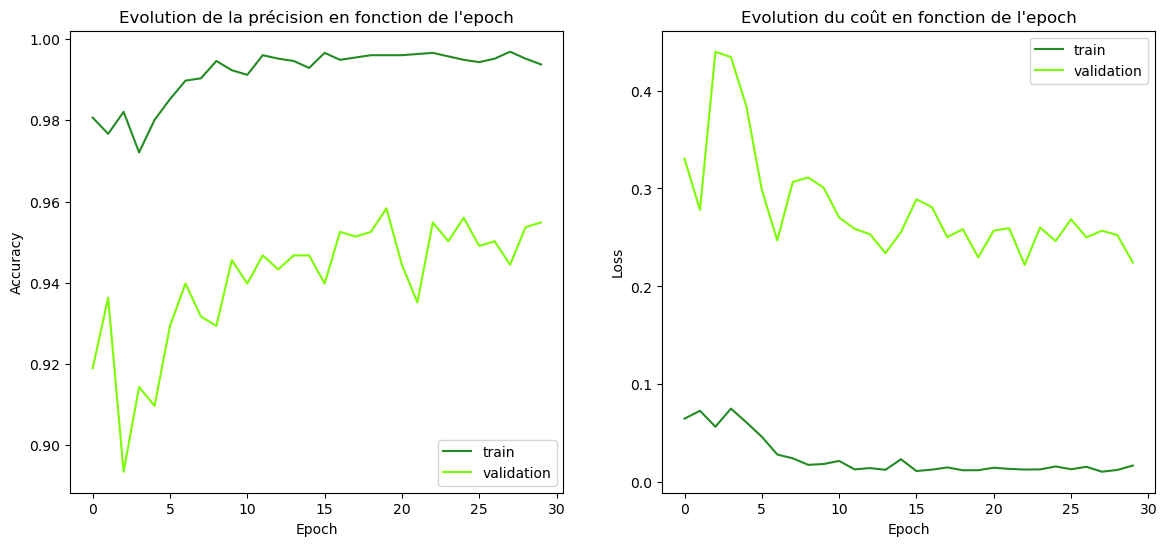

In [80]:
def plot_history():
    #Afficher la courbe de la fonction de coût et de précision en fonction de l'epoch
    training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    ax[0].plot(training_history['accuracy'], color='forestgreen')
    ax[0].plot(training_history['val_accuracy'], color='lawngreen')
    ax[0].set_title("Evolution de la précision en fonction de l'epoch")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(['train', 'validation'], loc='best');
    ax[1].plot(training_history['loss'], color='forestgreen')
    ax[1].plot(training_history['val_loss'], color='lawngreen')
    ax[1].set_title("Evolution du coût en fonction de l'epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend(['train', 'validation'], loc='best');

plot_history()
plt.show()

In [81]:
model.load_weights(checkpoint_filepath)

35/35 [==============================] - 11s 296ms/step
                           precision    recall  f1-score   support

              Black-grass       0.79      0.68      0.73        62
                 Charlock       1.00      0.99      0.99        90
                 Cleavers       1.00      0.99      0.99        67
         Common Chickweed       0.99      0.99      0.99       143
             Common wheat       0.94      0.94      0.94        51
                  Fat Hen       0.99      0.99      0.99       108
         Loose Silky-bent       0.88      0.94      0.91       152
                    Maize       0.96      0.94      0.95        51
        Scentless Mayweed       0.94      0.98      0.96       121
         Shepherd’s Purse       1.00      0.89      0.94        55
Small-flowered Cranesbill       1.00      0.99      1.00       115
               Sugar beet       0.97      0.98      0.97        93

                 accuracy                           0.95      1108
    

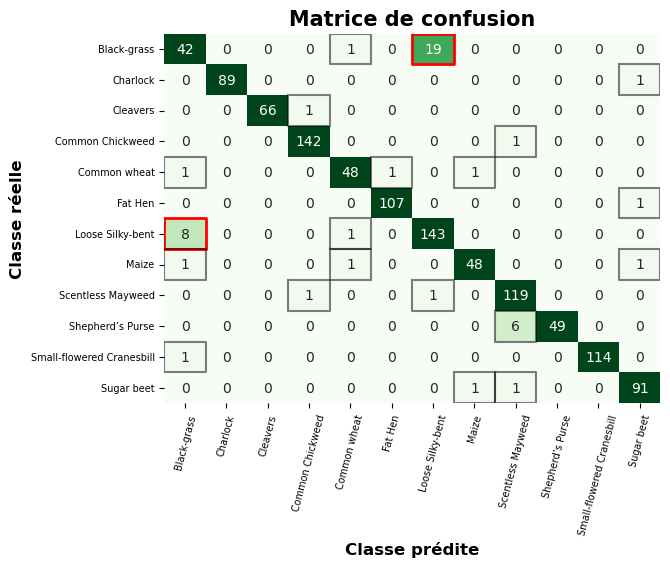

In [82]:
def show_metrics():
    y_true = test_iterator.classes #ou .labels
    y_pred = model.predict(test_iterator).argmax(axis=-1)
    #Evaluation du modèle : rapport de classification & matrice de confusion
    print(classification_report(y_true, y_pred, target_names = df.species.unique()))
    matrix = confusion_matrix(y_true, y_pred)
    classes = df.species.unique()
    sns.heatmap(matrix, annot=True,cmap="Greens", fmt = 'd',vmin=0,vmax=30,cbar=False)
    tick_marks = np.arange(0.5, len(classes), 1)
    plt.xticks(tick_marks, classes, rotation=75, fontsize = 7)
    plt.yticks(tick_marks, classes, rotation=0, fontsize = 7)
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        if (i!=j) and (matrix[i,j] !=0):
            if (matrix[i,j] > matrix.mean()):
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="red", linewidth=2)
            else:
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="k", alpha = 0.5)
    plt.ylabel("Classe réelle", fontweight = 'bold', fontsize = 12)
    plt.xlabel("Classe prédite", fontweight = 'bold', fontsize = 12)
    plt.title("Matrice de confusion", fontweight = 'extra bold', fontsize = 15);
    
show_metrics()
plt.show()

In [83]:
# Etape 2.8: Dé-freeze de tous les blocs (2 et 1 et le reste) du modèle de base
for layer in base_model.layers[0:]:
    layer.trainable = True
    
for i,layer in enumerate(base_model.layers):
    print(i,layer.name,"Trainable:",layer.trainable)

0 input_1 Trainable: True
1 Conv1 Trainable: True
2 bn_Conv1 Trainable: True
3 Conv1_relu Trainable: True
4 expanded_conv_depthwise Trainable: True
5 expanded_conv_depthwise_BN Trainable: True
6 expanded_conv_depthwise_relu Trainable: True
7 expanded_conv_project Trainable: True
8 expanded_conv_project_BN Trainable: True
9 block_1_expand Trainable: True
10 block_1_expand_BN Trainable: True
11 block_1_expand_relu Trainable: True
12 block_1_pad Trainable: True
13 block_1_depthwise Trainable: True
14 block_1_depthwise_BN Trainable: True
15 block_1_depthwise_relu Trainable: True
16 block_1_project Trainable: True
17 block_1_project_BN Trainable: True
18 block_2_expand Trainable: True
19 block_2_expand_BN Trainable: True
20 block_2_expand_relu Trainable: True
21 block_2_depthwise Trainable: True
22 block_2_depthwise_BN Trainable: True
23 block_2_depthwise_relu Trainable: True
24 block_2_project Trainable: True
25 block_2_project_BN Trainable: True
26 block_2_add Trainable: True
27 block_3_e

In [84]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_DeFreeze','DeFreeze_8','best_weights.ckpt')
csvlogger_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_Defreeze','DeFreeze_8','training_history.csv')
loadweights_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_DeFreeze','DeFreeze_7','best_weights.ckpt')
lr=1.e-4
nb_epochs=40

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Epoch 1/40
110/110 [==============================] - ETA: 0s - loss: 0.0798 - accuracy: 0.9747
Epoch 1: val_accuracy improved from -inf to 0.91319, saving model to Models_training/MobileNetV2_SansSeg_SansZoom_DeFreeze/DeFreeze_8/best_weights.ckpt
110/110 [==============================] - 192s 2s/step - loss: 0.0798 - accuracy: 0.9747 - val_loss: 0.5083 - val_accuracy: 0.9132 - lr: 1.0000e-04
Epoch 2/40
110/110 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9832
Epoch 2: val_accuracy improved from 0.91319 to 0.93287, saving model to Models_training/MobileNetV2_SansSeg_SansZoom_DeFreeze/DeFreeze_8/best_weights.ckpt
110/110 [==============================] - 201s 2s/step - loss: 0.0541 - accuracy: 0.9832 - val_loss: 0.3776 - val_accuracy: 0.9329 - lr: 1.0000e-04
Epoch 3/40
110/110 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.9769
Epoch 3: val_accuracy did not improve from 0.93287
110/110 [==============================] - 192s 2s/step 

110/110 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 0.9966
Epoch 25: val_accuracy did not improve from 0.94792
110/110 [==============================] - 169s 2s/step - loss: 0.0087 - accuracy: 0.9966 - val_loss: 0.2547 - val_accuracy: 0.9479 - lr: 7.8125e-07
Epoch 26/40
110/110 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.9957
Epoch 26: val_accuracy did not improve from 0.94792
110/110 [==============================] - 169s 2s/step - loss: 0.0140 - accuracy: 0.9957 - val_loss: 0.2658 - val_accuracy: 0.9468 - lr: 7.8125e-07
Epoch 27/40
110/110 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9957
Epoch 27: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 27: val_accuracy improved from 0.94792 to 0.94907, saving model to Models_training/MobileNetV2_SansSeg_SansZoom_DeFreeze/DeFreeze_8/best_weights.ckpt
110/110 [==============================] - 169s 2s/step - loss: 0.0141 - accuracy: 0.

In [85]:
# Calcul de la durée de l'entrainement
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")# Résultats de l'entrainement 

Durée de l'entraînement: 117.0 minutes.


In [86]:
training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
training_history.head()

,accuracy,loss,lr,val_accuracy,val_loss
epoch,,,,,
0,0.974666,0.079830,0.0001,0.913194,0.508272
1,0.983205,0.054082,0.0001,0.932870,0.377557
2,0.976943,0.071202,0.0001,0.929398,0.339325
3,0.980359,0.060722,0.0001,0.885417,0.465609
4,0.983490,0.049693,0.0001,0.915509,0.403816


In [87]:
# Trouve l'index de la ligne avec la valeur maximale de val_accuracy
max_val_accuracy_idx = training_history['val_accuracy'].idxmax()

# Sélectionne la ligne correspondante et affiche toutes les colonnes
row_with_max_val_accuracy = training_history.loc[max_val_accuracy_idx]
print('Valeurs Max')
print(row_with_max_val_accuracy)

# Trouve l'index de la ligne avec la valeur min de val_accuracy
min_val_accuracy_idx = training_history['val_accuracy'].idxmin()

# Sélectionne la ligne correspondante et affiche toutes les colonnes
row_with_min_val_accuracy = training_history.loc[min_val_accuracy_idx]
print('Valeurs Min')
print(row_with_min_val_accuracy)

column_means = training_history.mean()
print('Valeurs Moyennes')
print(column_means)

Valeurs Max
accuracy        9.962994e-01
loss            1.193052e-02
lr              3.906250e-07
val_accuracy    9.548611e-01
val_loss        2.444155e-01
Name: 30, dtype: float64
Valeurs Min
accuracy        0.980359
loss            0.060722
lr              0.000100
val_accuracy    0.885417
val_loss        0.465609
Name: 3, dtype: float64
Valeurs Moyennes
accuracy        0.993204
loss            0.021297
lr              0.000020
val_accuracy    0.936719
val_loss        0.301741
dtype: float64


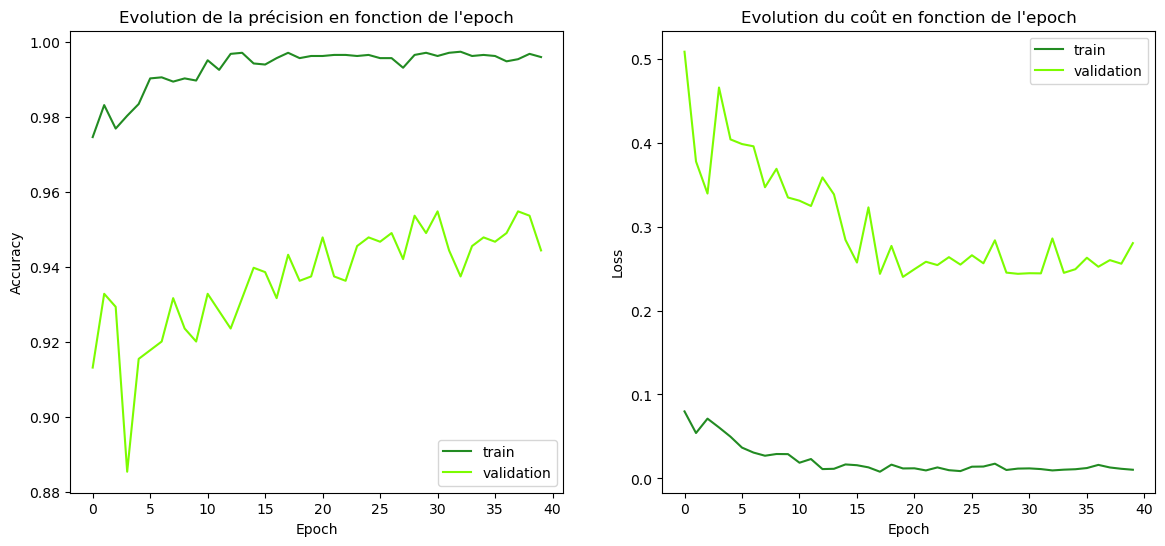

In [88]:
def plot_history():
    #Afficher la courbe de la fonction de coût et de précision en fonction de l'epoch
    training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    ax[0].plot(training_history['accuracy'], color='forestgreen')
    ax[0].plot(training_history['val_accuracy'], color='lawngreen')
    ax[0].set_title("Evolution de la précision en fonction de l'epoch")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(['train', 'validation'], loc='best');
    ax[1].plot(training_history['loss'], color='forestgreen')
    ax[1].plot(training_history['val_loss'], color='lawngreen')
    ax[1].set_title("Evolution du coût en fonction de l'epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend(['train', 'validation'], loc='best');

plot_history()
plt.show()

In [89]:
model.load_weights(checkpoint_filepath)

35/35 [==============================] - 11s 303ms/step
                           precision    recall  f1-score   support

              Black-grass       0.68      0.61      0.64        62
                 Charlock       0.98      0.99      0.98        90
                 Cleavers       0.97      0.99      0.98        67
         Common Chickweed       0.99      1.00      0.99       143
             Common wheat       0.98      0.90      0.94        51
                  Fat Hen       1.00      0.95      0.98       108
         Loose Silky-bent       0.85      0.92      0.89       152
                    Maize       0.98      0.98      0.98        51
        Scentless Mayweed       0.96      0.98      0.97       121
         Shepherd’s Purse       0.98      0.91      0.94        55
Small-flowered Cranesbill       1.00      0.99      1.00       115
               Sugar beet       0.97      0.98      0.97        93

                 accuracy                           0.95      1108
    

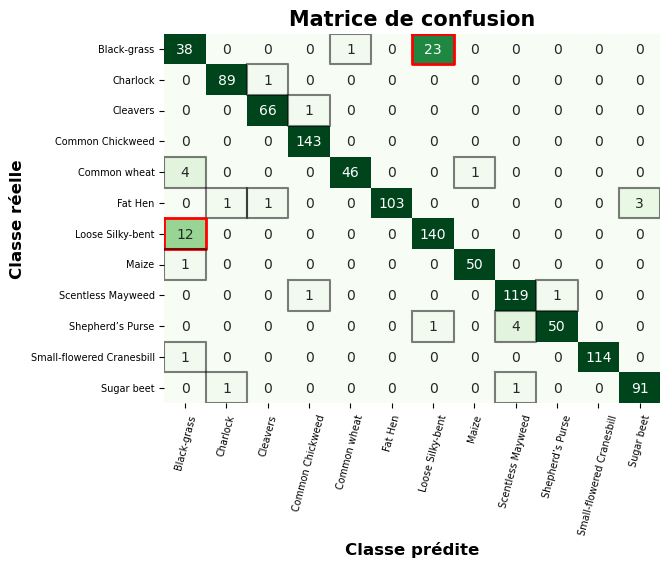

In [90]:
def show_metrics():
    y_true = test_iterator.classes #ou .labels
    y_pred = model.predict(test_iterator).argmax(axis=-1)
    #Evaluation du modèle : rapport de classification & matrice de confusion
    print(classification_report(y_true, y_pred, target_names = df.species.unique()))
    matrix = confusion_matrix(y_true, y_pred)
    classes = df.species.unique()
    sns.heatmap(matrix, annot=True,cmap="Greens", fmt = 'd',vmin=0,vmax=30,cbar=False)
    tick_marks = np.arange(0.5, len(classes), 1)
    plt.xticks(tick_marks, classes, rotation=75, fontsize = 7)
    plt.yticks(tick_marks, classes, rotation=0, fontsize = 7)
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        if (i!=j) and (matrix[i,j] !=0):
            if (matrix[i,j] > matrix.mean()):
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="red", linewidth=2)
            else:
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="k", alpha = 0.5)
    plt.ylabel("Classe réelle", fontweight = 'bold', fontsize = 12)
    plt.xlabel("Classe prédite", fontweight = 'bold', fontsize = 12)
    plt.title("Matrice de confusion", fontweight = 'extra bold', fontsize = 15);
    
show_metrics()
plt.show()

In [91]:
# Sauvegarde du modèle complet (intégralement dé-freezé et entraîné) au format TensorFlow SavedModel
saving_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_DeFreeze','DeFreeze_9','Final_model')
model.save(saving_filepath)

INFO:tensorflow:Assets written to: Models_training/MobileNetV2_SansSeg_SansZoom_DeFreeze/DeFreeze_9/Final_model/assets


INFO:tensorflow:Assets written to: Models_training/MobileNetV2_SansSeg_SansZoom_DeFreeze/DeFreeze_9/Final_model/assets


In [92]:
# Evaluation du modele sur les 3 échantillons
res_train = model.evaluate(train_iterator)
res_valid = model.evaluate(validation_iterator)
res_test = model.evaluate(test_iterator)

35/35 [==============================] - 10s 290ms/step - loss: 0.2141 - accuracy: 0.9468


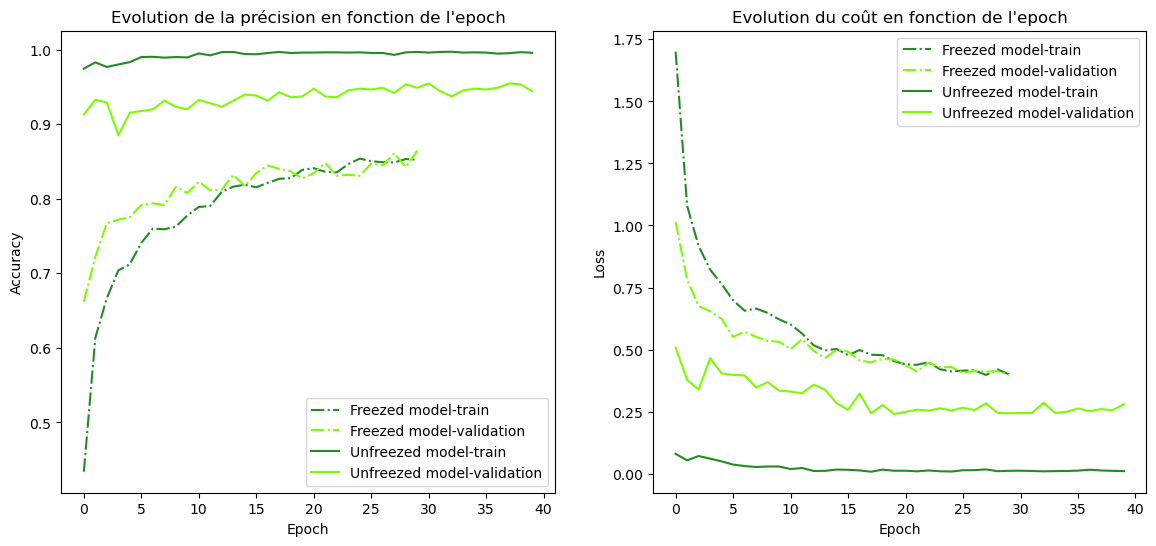

In [96]:
# Visualisation des courbes de convergence de la fonction de coût et de l'accuracy au long de l'entraînement 
# pour le modèle freezé, et pour le modèle intégralemet dé-freezé
csvlogger_filepath_freeze = Path('Models_training','MobileNetV2_SansSeg_SansZoom_Defreeze','Freeze','training_history.csv')
csvlogger_filepath_unfreeze = Path('Models_training','MobileNetV2_SansSeg_SansZoom_Defreeze','DeFreeze_8','training_history.csv')

def plot_history():
    #Afficher la courbe de la fonction de coût et de précision en fonction de l'epoch
    training_history_freeze = pd.read_csv(csvlogger_filepath_freeze,index_col = 'epoch')
    training_history_unfreeze = pd.read_csv(csvlogger_filepath_unfreeze,index_col = 'epoch')
    
    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    ax[0].plot(training_history_freeze['accuracy'],linestyle='-.',color='forestgreen',label="Freezed model-train")
    ax[0].plot(training_history_freeze['val_accuracy'],linestyle='-.',color='lawngreen',label="Freezed model-validation")
    ax[0].plot(training_history_unfreeze['accuracy'], color='forestgreen',label="Unfreezed model-train")
    ax[0].plot(training_history_unfreeze['val_accuracy'], color='lawngreen',label="Unfreezed model-validation")
    ax[0].set_title("Evolution de la précision en fonction de l'epoch")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(loc='best');
    ax[1].plot(training_history_freeze['loss'],linestyle='-.',color='forestgreen',label="Freezed model-train")
    ax[1].plot(training_history_freeze['val_loss'],linestyle='-.',color='lawngreen',label="Freezed model-validation")
    ax[1].plot(training_history_unfreeze['loss'],color='forestgreen',label="Unfreezed model-train")
    ax[1].plot(training_history_unfreeze['val_loss'],color='lawngreen',label="Unfreezed model-validation")
    ax[1].set_title("Evolution du coût en fonction de l'epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend(loc='best');
    
plot_history()

In [99]:
# Visualisation des courbes de dé-freezage

# Récupération des valeurs de loss et accuracy pour le modèle freezé et les dé-freeze successifs
loss=[]
accuracy=[]
val_loss=[]
val_accuracy=[]

# Modèle Freezé
loadweights_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_DeFreeze','Freeze','best_weights.ckpt')
print("Loading model weights - Freeze")
model.load_weights(loadweights_filepath)
print("Compiling model")
model.compile(optimizer=Adam(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics='accuracy')
print("Evaluating model")
train_res = model.evaluate(train_iterator)
loss.append(train_res[0])
accuracy.append(train_res[1])
val_res = model.evaluate(validation_iterator)
val_loss.append(val_res[0])
val_accuracy.append(val_res[1])

# De-freeze successifs
nb_defreeze = 8
for k in range(nb_defreeze):
    directory = "DeFreeze_"+str(k+1)
    loadweights_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom_DeFreeze',directory,'best_weights.ckpt')
    print("Loading model weights - Unfreeze",str(k+1))
    model.load_weights(loadweights_filepath)
    print("Compiling model")
    model.compile(optimizer=Adam(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics='accuracy')
    print("Evaluating model")
    train_res = model.evaluate(train_iterator)
    loss.append(train_res[0])
    accuracy.append(train_res[1])
    val_res = model.evaluate(validation_iterator)
    val_loss.append(val_res[0])
    val_accuracy.append(val_res[1])

Loading model weights - Freeze
Compiling model
Evaluating model
28/28 [==============================] - 15s 513ms/step - loss: 0.4301 - accuracy: 0.8476
Loading model weights - Unfreeze 1
Compiling model
Evaluating model
28/28 [==============================] - 15s 524ms/step - loss: 0.2966 - accuracy: 0.9041
Loading model weights - Unfreeze 2
Compiling model
Evaluating model
28/28 [==============================] - 16s 548ms/step - loss: 0.2591 - accuracy: 0.9300
Loading model weights - Unfreeze 3
Compiling model
Evaluating model
28/28 [==============================] - 15s 513ms/step - loss: 0.2514 - accuracy: 0.9334
Loading model weights - Unfreeze 4
Compiling model
Evaluating model
28/28 [==============================] - 14s 503ms/step - loss: 0.2497 - accuracy: 0.9368
Loading model weights - Unfreeze 5
Compiling model
Evaluating model
28/28 [==============================] - 15s 514ms/step - loss: 0.2758 - accuracy: 0.9436
Loading model weights - Unfreeze 6
Compiling model
Evalu

In [100]:
len(accuracy)

9

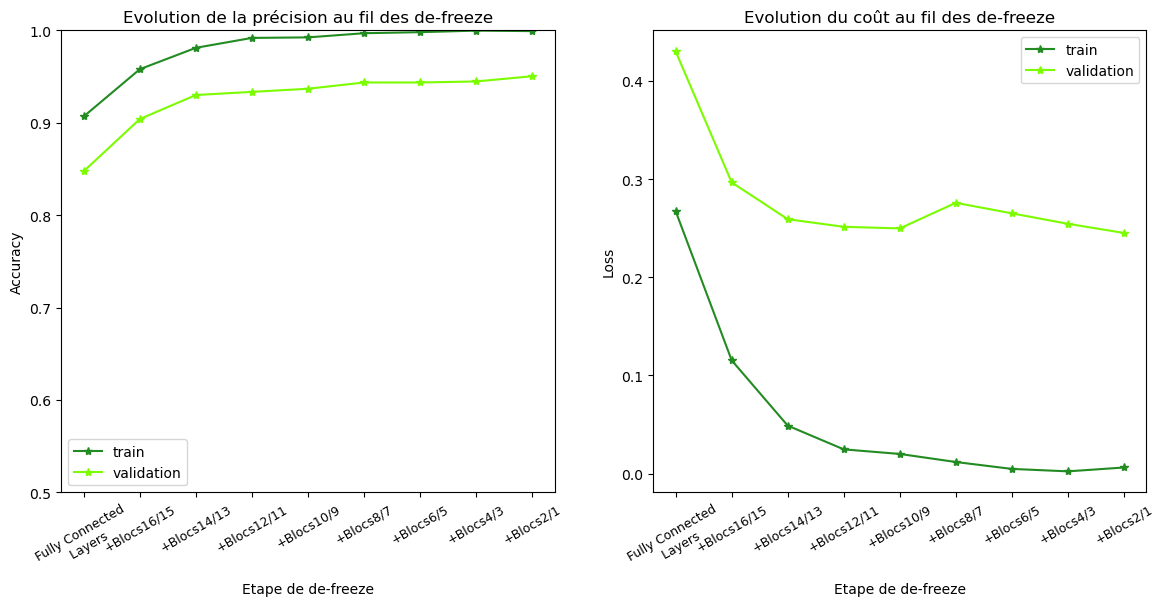

In [101]:
# Tracé des courbes de dé-freezage

fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].plot(accuracy, color='forestgreen', marker = "*")
ax[0].plot(val_accuracy, color='lawngreen', marker = "*")
ax[0].set_title("Evolution de la précision au fil des de-freeze")
ax[0].set_xlabel("Etape de de-freeze")
ax[0].set_ylabel("Accuracy")
xticklabels=["Fully Connected\n Layers", "+Blocs16/15", "+Blocs14/13", "+Blocs12/11", "+Blocs10/9", 
             "+Blocs8/7", "+Blocs6/5", "+Blocs4/3", "+Blocs2/1"]
ax[0].set_xticks(range(9))
ax[0].set_xticklabels(xticklabels, rotation=30, fontsize=9)
ax[0].set_ylim(0.5,1)
ax[0].legend(['train', 'validation'], loc='best');
ax[1].plot(loss, color='forestgreen', marker = "*")
ax[1].plot(val_loss, color='lawngreen', marker = "*")
ax[1].set_title("Evolution du coût au fil des de-freeze")
ax[1].set_xlabel("Etape de de-freeze")
ax[1].set_ylabel("Loss")
ax[1].set_xticks(range(9))
ax[1].set_xticklabels(xticklabels, rotation=30, fontsize=9)
ax[1].legend(['train', 'validation'], loc='best');